In [19]:
import numpy as np
# import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, Booster
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import torch
import torch.nn.functional as F

from torchvision import datasets, transforms
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import cv2
from typing import List, Callable
from torch.utils.data import Dataset, DataLoader
from icecream import ic
from scipy.fftpack import dct
from sklearn.metrics import confusion_matrix

In [20]:
xgb.set_config(verbosity=2)
xgb.get_config()

{'use_rmm': False, 'verbosity': 2}

In [21]:
x = np.array([-2.0,2.0])
lr = .001
def grad_x(x): # f(x) = x**4
    return 4*x**3

step =  lr*grad_x(x)
x_2 =  x - step

d2 = grad_x(x_2) - grad_x(x)
d2x = - step
d2/d2x ,d2, step , x_2 , 12*x**2 , -(grad_x(x_2)/(- grad_x(x))+1)/lr

(array([47.236096, 47.236096]),
 array([ 1.51155507, -1.51155507]),
 array([-0.032,  0.032]),
 array([-1.968,  1.968]),
 array([48., 48.]),
 array([-47.236096, -47.236096]))

In [22]:
class MNIST_Seq(Dataset):
    """Sequenced CIFAR dataset."""

    def __init__(self, dataset, positional_encoding_size = 10, transform=None):
        """
        Arguments:
            dataset   (Dataset): torch standard dataset with annotations.
            
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.patch_size = 4
        self.stride = 4
        self.scale = 1
        self.block_size = int(((28-self.patch_size)//self.stride +1 )**2)
        self.positional_encoding_size = positional_encoding_size
        
        self.dataset = dataset
        self.pos_encoding = getPositionEncoding(seq_len=self.block_size, d=positional_encoding_size, n=self.block_size)

        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def image2seq(self, im):
        seq = [(im[x:x+self.patch_size,y:y+self.patch_size]).flatten() /(255)*self.scale
               for x in range(0,im.shape[0]-self.patch_size+1,self.stride)
               for y in range(0,im.shape[1]-self.patch_size+1,self.stride)]
    
        return np.concatenate([np.stack(seq),self.pos_encoding] , axis = -1)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image , target = self.dataset[idx]
        label = target#0 if target == 3 else 1
        image_seq = self.image2seq(np.array(image))
        sample = {'image_seq': image_seq, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [23]:
# transform_train = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
#                                       # transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
#                                       # transforms.RandomRotation(10),     #Rotates the image to a specified angel
#                                       # transforms.RandomAffine(degrees=5,translate=(.1,.1), scale=(0.9,1.1)), #Performs actions like zooms, change shear angles.
#                                       transforms.ColorJitter(brightness=0.01, contrast=0.01, saturation=0.01)
#                                ])
transform_train = None

In [24]:
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    # P = (((P + 1) / 2) * 255).astype(np.uint8) # normalized position
    return P

# positional_encoding_size = 10

# P = getPositionEncoding(seq_len=block_size, d=positional_encoding_size, n=block_size)

In [25]:
# CIFAR_Train = datasets.CIFAR10('./mnist' , download=False, transform=transform_train)
# CIFAR_Test = datasets.CIFAR10('./mnist' ,train=False, download=False)

Trainset = datasets.FashionMNIST('./data' , download=True, transform=transform_train)
Testset = datasets.FashionMNIST('./data' ,train=False, download=True)
ic(len(Trainset) , len(Testset))

ic| len(Trainset): 60000, len(Testset): 10000


(60000, 10000)

In [26]:
MNIST_Seq_Train =  MNIST_Seq (Trainset)
MNIST_Seq_Test =  MNIST_Seq (Testset)

In [27]:
def vis(im,t):
    im = np.array(im)
    imax = plt.imshow(im)
    plt.title(Trainset.classes[t])
    imax.axes.set_axis_off()
    plt.show()
    patch_size = MNIST_Seq_Train.patch_size
    stride = MNIST_Seq_Train.stride
    tiles = [im[x:x+patch_size,y:y+patch_size] for x in range(0,im.shape[0]-patch_size+1,stride) for y in range(0,im.shape[1]-patch_size+1,stride)]
    feature_map_size = int((im.shape[0]-patch_size)/stride +1)
    fig, axs = plt.subplots(feature_map_size, feature_map_size)
    for i , p in enumerate(tiles) :
        axs[i//feature_map_size,i%feature_map_size].imshow(p , vmax=255,vmin=0)
        axs[i//feature_map_size,i%feature_map_size].set_axis_off()
        
    plt.subplots_adjust(wspace=-.7, hspace=.03)
    plt.show()
    print(len(tiles))
    print(list(range(0,im.shape[0]-patch_size+1,stride)))
    
    print(feature_map_size)
    # plt.hist(im.flatten())
    # plt.show()

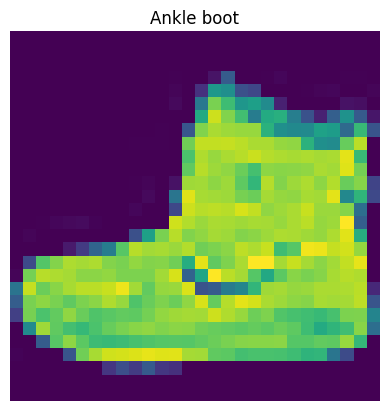

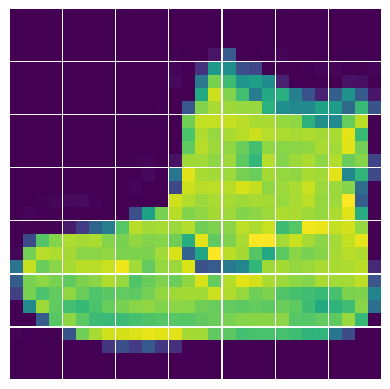

49
[0, 4, 8, 12, 16, 20, 24]
7


In [28]:
# only for visualization
for i in range(1):
    im ,t= Trainset[i]
    vis(im,t)


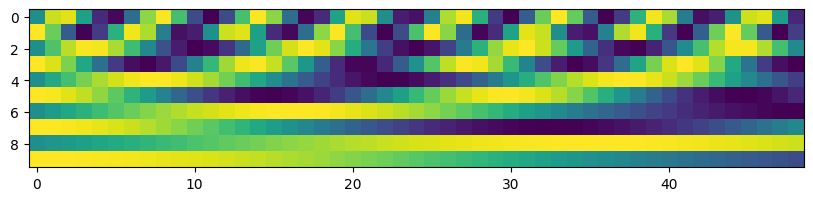

In [29]:
plt.figure(figsize=(10,3))
plt.imshow(MNIST_Seq_Train.pos_encoding.T)
plt.show()

ic| data_dict['image_seq'][:,:,:MNIST_Seq_Train.patch_size**2].max(): tensor(1., dtype=torch.float64)
ic| data_dict['image_seq'].shape: torch.Size([1000, 49, 26])
    data_dict['label'].shape: torch.Size([1000])


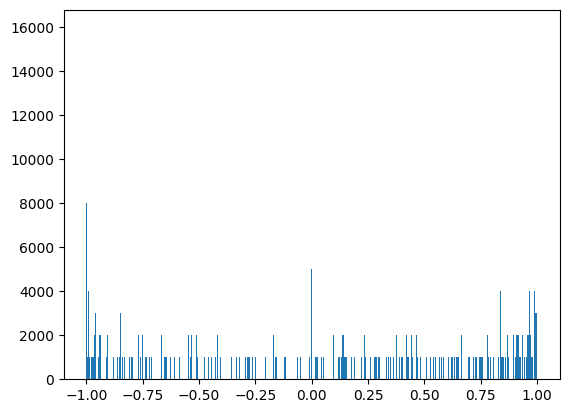

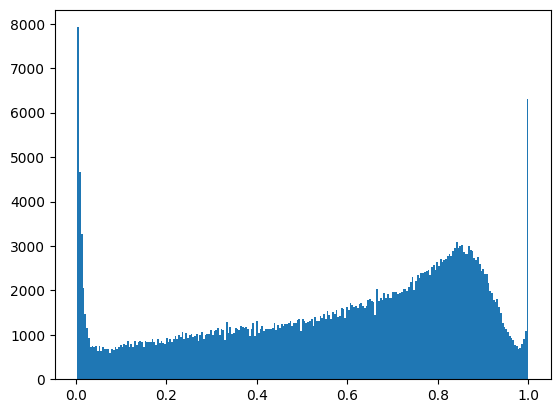

In [30]:
batch_size = 1000
TrainLoader = DataLoader(MNIST_Seq_Train,batch_size = batch_size ,num_workers=2, shuffle=True)
TestLoader = DataLoader(MNIST_Seq_Test,batch_size = batch_size)

itert = iter(TrainLoader)
data_dict =  next(itert)
ic(data_dict['image_seq'][:,:,:MNIST_Seq_Train.patch_size**2].max())
ic(data_dict['image_seq'].shape , data_dict['label'].shape)
a = plt.hist(data_dict['image_seq'][:,:,MNIST_Seq_Train.patch_size**2:].numpy().flatten() , bins=1000)
plt.show()
a = plt.hist(data_dict['image_seq'][:,:,:MNIST_Seq_Train.patch_size**2].numpy().flatten()[
             np.where(np.abs(data_dict['image_seq'][:,:,:MNIST_Seq_Train.patch_size**2].numpy().flatten())>0)],bins=255)
plt.show()


In [31]:
block_size = ic(MNIST_Seq_Train.block_size)
positional_encoding_size = ic(MNIST_Seq_Train.positional_encoding_size)


ic| MNIST_Seq_Train.block_size: 49
ic| MNIST_Seq_Train.positional_encoding_size: 10


In [32]:
embeding_dim =  50 # key , query size 
num_class  = 10
value_dim = 10
n_head = 1
input_dim =(MNIST_Seq_Train.patch_size**2) + MNIST_Seq_Train.positional_encoding_size 
flash = False

In [33]:
use_input = False
def base4kq(dt):
    input_array = dt.get_data().toarray()  #/255 -.5
    
    datak = np.pad(input_array, [(0,0),(embeding_dim, 0)], 'reflect') [:,:embeding_dim]
    # dataq = np.pad(input_array, [(0,0),(embeding_dim, 0)], 'reflect') [:,-embeding_dim:]
    return np.concatenate([datak,datak], axis=-1)

In [34]:

def obj_init(predicts, dtrain):
    ggrad = np.random.randn(*predicts.shape) #@+ggrad*.1
    ggrad = ggrad.flatten()
    hess = ggrad*0+0.001
    
    return ggrad, hess

key_query_param = {'max_depth':7, 'base_score':.0 , 'subsample': 1,
         'tree_method':'auto', 'multi_strategy': 'multi_output_tree',
         'min_child_weight' : .000,  # default=1
         'eta': 0.03, # default=.3
         'num_feature':input_dim,
         'num_class': embeding_dim,
            'lambda':1 } # default=1

value_param = {'max_depth':7, 'base_score':0 , 'subsample': 1,
         'tree_method':'auto', 'multi_strategy': 'multi_output_tree',
         'min_child_weight' : .000, # default=1
         'eta': 0.001, # default=.3
         'num_feature':input_dim,
         'num_class': value_dim,
              'lambda': 1} # default=1

key_booster = Booster(key_query_param)
query_booster = Booster(key_query_param)
value_booster = Booster(value_param)

for i, data in enumerate(TrainLoader):
    
    x , target = data['image_seq'] , data['label']
    model_XT = x.reshape(-1,input_dim)
    dtrain = xgb.DMatrix(model_XT.numpy())
    
    key_outputs = key_booster.predict(dtrain, output_margin=True)
    grad, hess = obj_init(key_outputs, dtrain)
    key_booster.boost(dtrain, grad, hess)
    
    query_outputs = query_booster.predict(dtrain, output_margin=True)
    grad, hess = obj_init(query_outputs, dtrain)
    query_booster.boost(dtrain, grad, hess)

    # value_outputs = value_booster.predict(dtrain, output_margin=True)
    # grad, hess = obj_init(value_outputs, dtrain)
    # value_booster.boost(dtrain, grad, hess)
    
    ic(i, grad.shape)
    if i >=4:
        break
    


ic| i: 0, grad.shape: (2450000,)
ic| i: 1, grad.shape: (2450000,)
ic| i: 2, grad.shape: (2450000,)
ic| i: 3, grad.shape: (2450000,)
ic| i: 4, grad.shape: (2450000,)


ic| out.shape: (49000, 50)


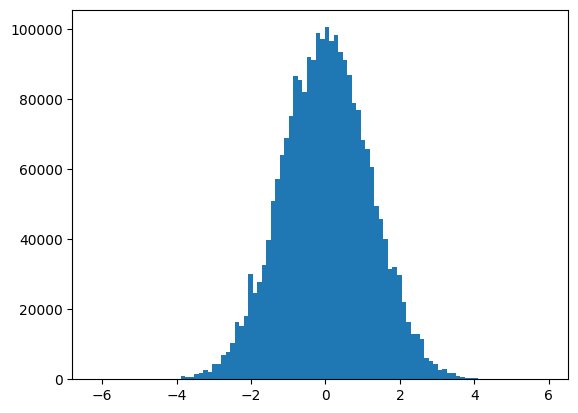

ic| out.shape: (49000, 50)


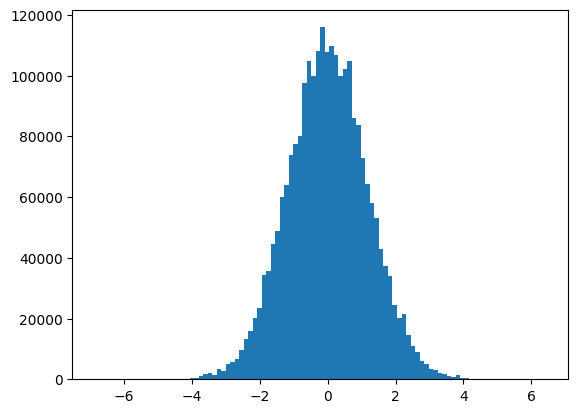

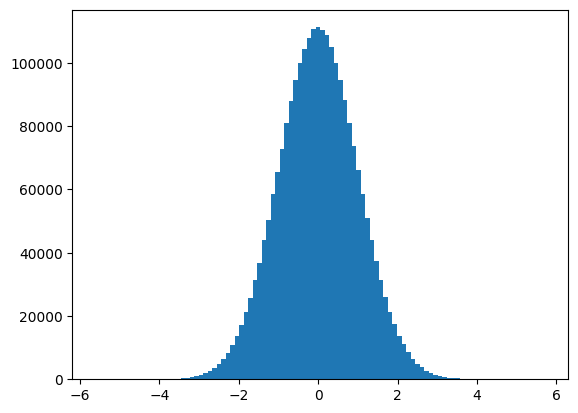

ic| out.shape: (49000, 10)


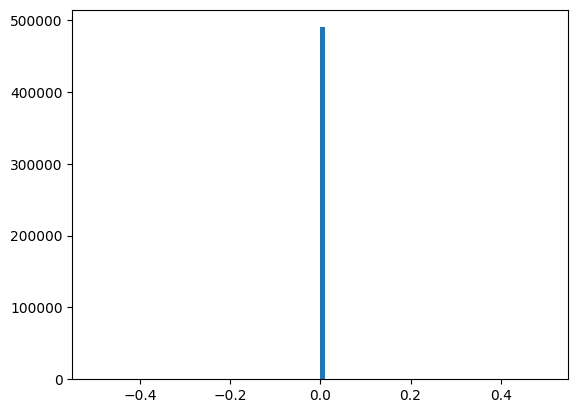

In [35]:
out = key_booster.predict(dtrain, output_margin=True)
ic(out.shape)
a = plt.hist(out.flatten(),bins =100)
plt.show()
out = query_booster.predict(dtrain, output_margin=True)
ic(out.shape)
a = plt.hist(out.flatten(),bins =100)
plt.show()
a = plt.hist(np.random.randn(*out.shape).flatten(),bins =100)
plt.show()
out = value_booster.predict(dtrain, output_margin=True)
ic(out.shape)
a = plt.hist(out.flatten(),bins =100)
plt.show()


# a = plt.hist(out[:,:value_dim].flatten(),bins =100)
# plt.show()

In [36]:
def predict_inner(key, query, value):

    values = value.reshape(-1,block_size,value_dim)
    keys = key.reshape(-1,block_size,embeding_dim)
    queries = query.reshape(-1,block_size, embeding_dim)
    
    B, T, C = keys.size()
    
    keys = keys.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
    queries = queries.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
    values = values.view(B, T, n_head, value_dim // n_head).transpose(1, 2) # (B, nh, T, hs)

    
    if flash:
        # efficient attention using Flash Attention CUDA kernels
        each_head_y = F.scaled_dot_product_attention(queries, keys, values, attn_mask=None, dropout_p= 0, is_causal=False)
    else:
        # manual implementation of attention
        att = (queries @ keys.transpose(-2, -1)) * (1.0 / np.sqrt(keys.size(-1)))
        att = F.softmax(att, dim=-1)


        each_head_y = att  @ values  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        
    output_seq = each_head_y.transpose(1, 2).contiguous().view(B, T, value_dim) # re-assemble all head outputs side by side
    output = (output_seq[:,:,:]).sum(1)
    return output


def predict(key, query, value, has_grad = True):

    approx_hess = True
    
    key = key.copy()
    query = query.copy()
    value = value.copy()
    
    key = torch.from_numpy(key).float().requires_grad_(True)
    query = torch.from_numpy(query).float().requires_grad_(True)
    value = torch.from_numpy(value).float().requires_grad_(True)

    output = predict_inner(key, query, value)
    
    grad = {}
    grad2 = {}
    hess = {}
    if has_grad:
        loss = 0
        loss += F.cross_entropy(output ,target,reduction='sum', label_smoothing=0.00)
        r_loss = loss.item()
        loss.backward()
        # print(keys.grad)
        grad["key"] = key.grad.numpy().flatten() *1
        grad["query"] = query.grad.numpy().flatten() *1
        grad["value"] = value.grad.numpy().flatten() *1
        

        if approx_hess:
            with torch.no_grad():
                key.data.add_(-0.01*key.grad)
                key.grad.zero_()
                query.data.add_(-0.01*query.grad)
                query.grad.zero_()
                value.data.add_(-0.01*value.grad)
                value.grad.zero_()

            output = predict_inner(key, query, value)
            loss = 0
            loss += F.cross_entropy(output ,target,reduction='sum', label_smoothing=0.00)
            loss.backward()

            grad2["key"] = key.grad.numpy().flatten()
            grad2["query"] = query.grad.numpy().flatten()
            grad2["value"] = value.grad.numpy().flatten()
            
            hess["key"] =  0.01* ((grad2["key"]     - grad["key"])/(- 0.01*grad["key"] - 
                                                               (2*(grad["key"] >= 0) - 1)*1e-6)).clip(min=1e-6,max=100)
            hess["query"] = 0.01*((grad2["query"] - grad["query"])/(- 0.01*grad["query"]- 
                                                               (2*(grad["query"] >= 0) - 1)*1e-6)).clip(min=1e-6,max=100)
            hess["value"] = 0.01*((grad2["value"] - grad["value"])/(- 0.01*grad["value"]- 
                                                               (2*(grad["value"] >= 0) - 1)*1e-6)).clip(min=1e-6,max=100)
        
        return output, grad, hess, r_loss
        
    return output

In [37]:
# hess["key"] =   .1*((grad2["key"]     - grad["key"])/(- 0.01*grad["key"] - 
#                                                                (2*(grad["key"] >= 0) - 1)*1e-6)).clip(min=1e-6,max=100)
#             hess["query"] = .1*((grad2["query"] - grad["query"])/(- 0.01*grad["query"]- 
#                                                                (2*(grad["query"] >= 0) - 1)*1e-6)).clip(min=1e-6,max=100)
#             hess["value"] = .1*((grad2["value"] - grad["value"])/(- 0.01*grad["value"]- 
#                                                                (2*(grad["value"] >= 0) - 1)*1e-6)).clip(min=1e-6,max=100)

In [38]:
            # hess["key"] =   ((grad2["key"]     - grad["key"])/(- 0.01*grad["key"] - 
            #                                                    (np.sign(grad["key"]))*1e-2)).clip(min=1e-6,max=100)
            # hess["query"] = ((grad2["query"] - grad["query"])/(- 0.01*grad["query"]- 
            #                                                    (np.sign(grad["query"]))*1e-2)).clip(min=1e-6,max=100)
            # hess["value"] = ((grad2["value"] - grad["value"])/(- 0.01*grad["value"]- 
            #                                                    (np.sign(grad["value"]))*1e-2)).clip(min=1e-6,max=100)

### INITIAL STATE

In [39]:
b = 0
all_test_preds = []
all_test_labels = []
all_model_outputs = []

for i, data in enumerate(TestLoader):
    print(i)
    x , target = data['image_seq'] , data['label']
    model_XT = x.reshape(-1,input_dim)
    
    dtrain = xgb.DMatrix(model_XT.numpy())
    
    key = key_booster.predict(dtrain, output_margin=True)
    query = query_booster.predict(dtrain, output_margin=True)
    value = value_booster.predict(dtrain, output_margin=True)
    with torch.no_grad():
        predicts = predict(key, query, value, has_grad=False)
    all_model_outputs.append(np.concatenate([value, key, query], axis=-1))
    yhat = predicts.argmax(dim=-1).numpy()
    all_test_preds.append(yhat)
    all_test_labels.append(target.numpy())
    break


preds = np.concatenate(all_test_preds)
labels = np.concatenate(all_test_labels)
model_outputs_test = np.concatenate(all_model_outputs)

0


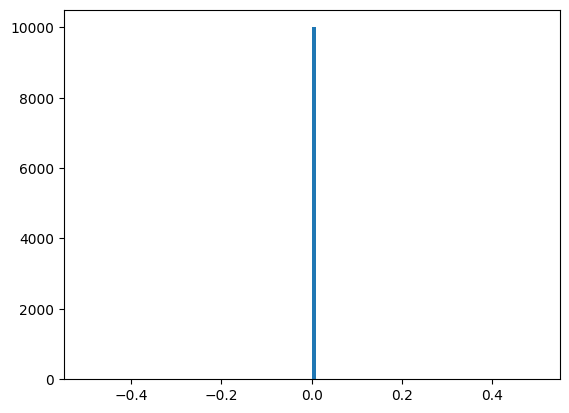

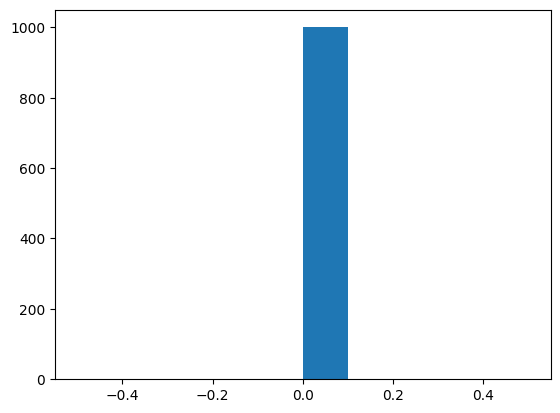

In [40]:
a = plt.hist(predicts.flatten(),bins =100)
plt.show()
a = plt.hist(yhat.flatten(),bins =10)
plt.show()

In [41]:
t=10

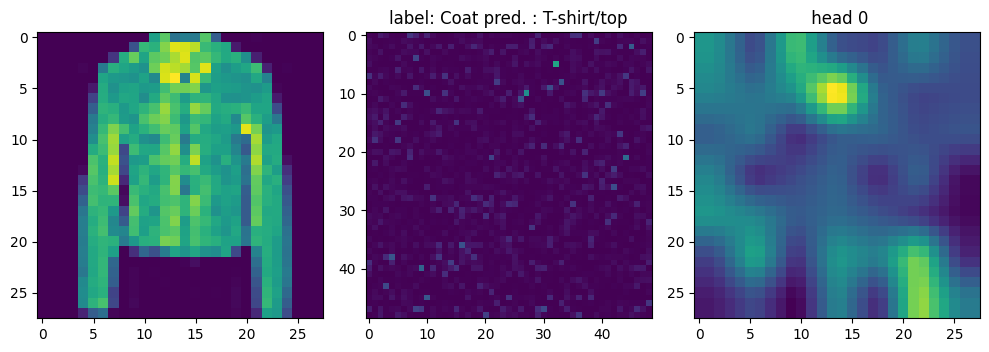

ic| t: 10


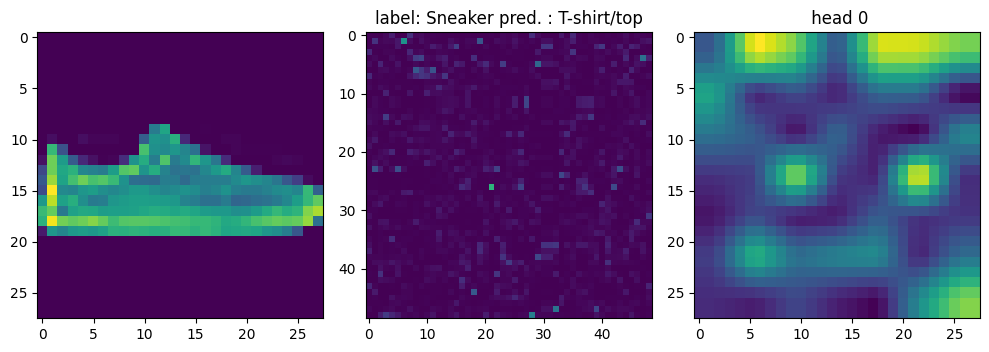

ic| t: 12


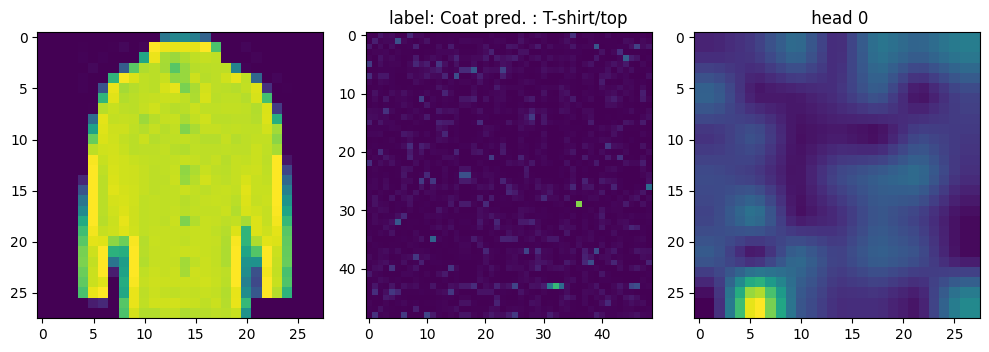

ic| t: 14


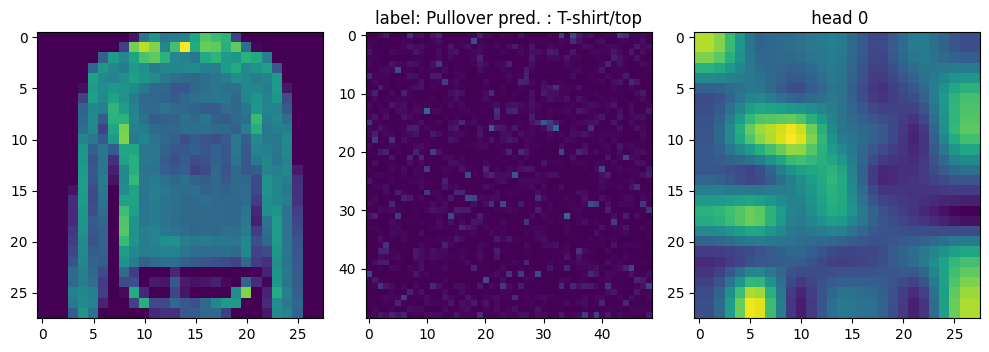

ic| t: 16


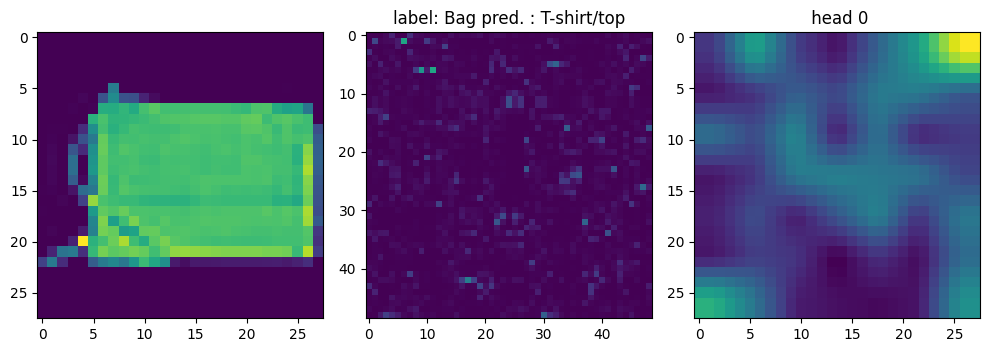

ic| t: 18


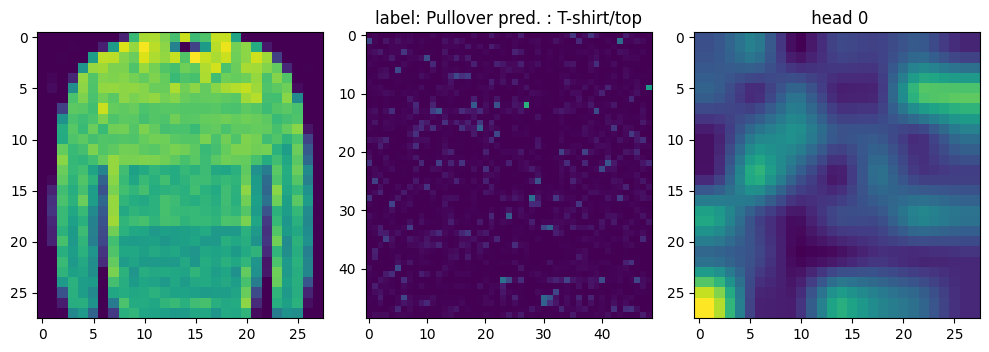

ic| t: 20


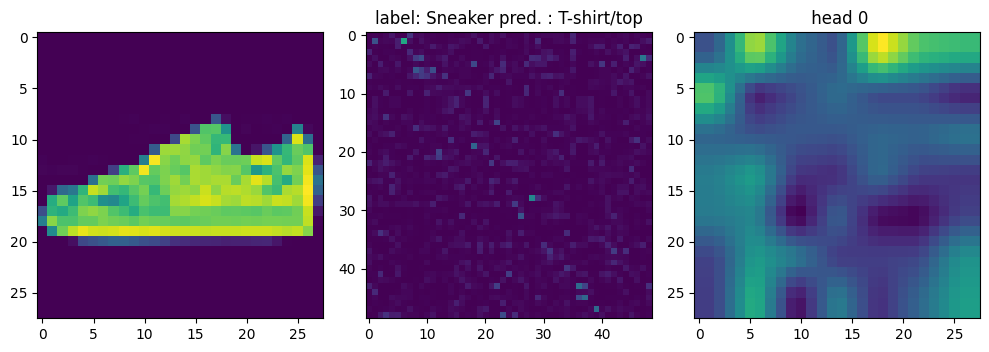

ic| t: 22


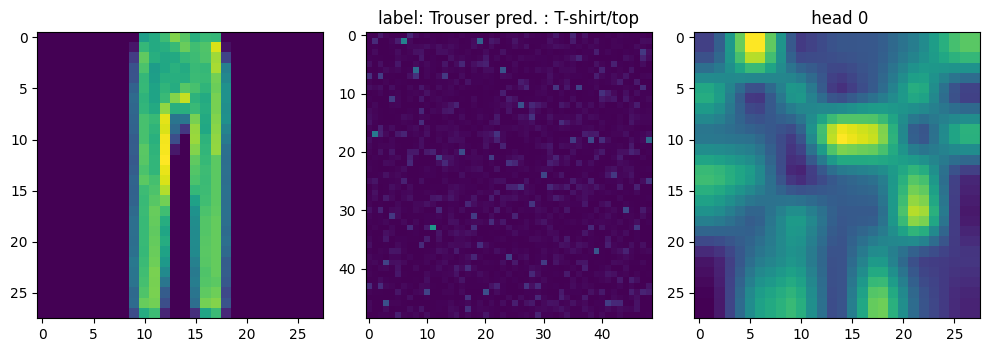

ic| t: 24


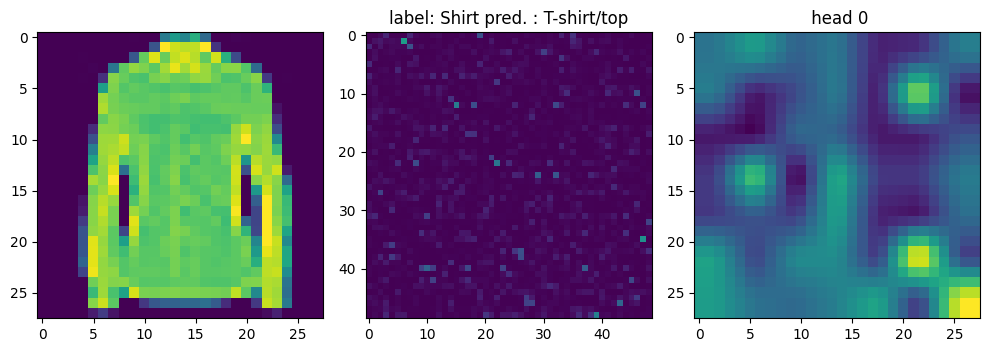

ic| t: 26


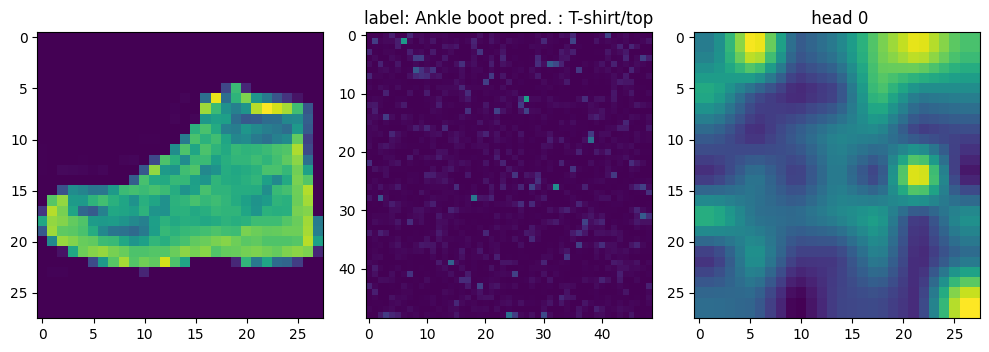

ic| t: 28


In [42]:
for c in range(10):
    
    if True:
        
        if n_head == 1:
            fig, axes = plt.subplots(1,3 , figsize=(10,7))
            axes = axes[None]
        else:
            fig, axes = plt.subplots(n_head,3 , figsize=(10,n_head*3))
        
        
        with torch.no_grad():
            pred0 = model_outputs_test[t*block_size:t*block_size + block_size]
#             pred0.shape
        pred0 = pred0.copy()
        
        pred0 = torch.from_numpy(pred0).float().requires_grad_(False)
        with torch.no_grad():
            values = pred0[:, :value_dim].reshape(-1,block_size,value_dim)
    
            keys = pred0[:, value_dim: value_dim + embeding_dim].reshape(-1,block_size,embeding_dim)
            queries = pred0[:, value_dim + embeding_dim:value_dim + 2*embeding_dim] .reshape(-1,block_size, embeding_dim)
            B, T, C = keys.size()
            
            keys = keys.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
            queries = queries.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
            values = values.view(B, T, n_head, value_dim // n_head).transpose(1, 2) # (B, nh, T, hs)
    
            if False:
                # efficient attention using Flash Attention CUDA kernels
                y = torch.nn.functional.scaled_dot_product_attention(queries, keys, values)
            else:
                # manual implementation of attention
                att = (queries @ keys.transpose(-2, -1)) * (1.0 / np.sqrt(keys.size(-1)))
                # att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf')) # causal implementation 
                att = F.softmax(att, dim=-1)
                # att = F.relu(att)
                y = att @ values  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
            output_seq = y.transpose(1, 2).contiguous().view(B, T, value_dim) # re-assemble all head outputs side by side
            output = (output_seq[:,:,:]).sum(1) #
            # ic(F.softmax(output,dim=-1))
            for i, head in enumerate(att[0]):
                axes[i,0].imshow(Testset.data[t])
                
                axes[i,1].imshow(head.T,vmin=0, vmax=1)
                # axes[i,1].imshow(F.relu(head.T),vmin=0)
                # axes[i,1].imshow(head.T)
                tttt = Testset.classes[preds[t]]
                axes[i,1].set_title('label: ' + str(Testset.classes[Testset.targets[t]]) + ' pred. : ' +  tttt )
                # plt.show()
                attention_mask = head.sum(0).reshape(int(block_size**.5),int(block_size**.5)).numpy()
    #             print( att.sum(0))
                image = cv2.resize(attention_mask, (28, 28))
                # ic(image)
                axes[i,2].imshow(image)
                axes[i,2].set_title(f' head {i}')
        #         axes[2].imshow(attention_mask)
    
        #         axes[2].imshow(att.sum(0).reshape(int(len(tiles)**.5),int(len(tiles)**.5)), interpolation="bicubic")
            fig.tight_layout()   
            plt.show()
    
    ic(t)
    t+=2

In [43]:
key_query_param = {'max_depth':9, 'base_score':.0,
         'tree_method':'hist', 'multi_strategy': 'multi_output_tree',
         'eta': .3,
         'num_feature':input_dim,
         'num_class': embeding_dim,
         'lambda':10 } # default=1

value_param = {'max_depth':9, 'base_score':.0,
         'tree_method':'hist', 'multi_strategy': 'multi_output_tree',
         'eta': .03,
         'num_feature':input_dim,
         'num_class': value_dim,
         'lambda':1 } # default=1


#grow_policy [default= depthwise]

# key_query_param = {'max_depth':7, 'base_score':.0 , 'subsample': 1,
#          'tree_method':'auto', 'multi_strategy': 'multi_output_tree',
#          'min_child_weight' : .000,  # default=1
#          'eta': 0.03, # default=.3
#          'num_feature':input_dim,
#          'num_class': embeding_dim,
#             'lambda':1 } # default=1

# value_param = {'max_depth':7, 'base_score':0 , 'subsample': 1,
#          'tree_method':'auto', 'multi_strategy': 'multi_output_tree',
#          'min_child_weight' : .000, # default=1
#          'eta': 0.03, # default=.3
#          'num_feature':input_dim,
#          'num_class': value_dim,
#               'lambda': 1} # default=1

key_booster.set_param(key_query_param)
query_booster.set_param(key_query_param)
value_booster.set_param(value_param)

it = 0


In [44]:
def plot():
    print('\n ############# grad \n')
    a = plt.hist(grad['key'].clip(min=-.05,max=.05),bins =1000, log=True)
    plt.title('key grad')
    plt.show()
    a = plt.hist(grad['query'].clip(min=-.05,max=.05),bins =1000, log=True)
    plt.title('query grad')
    plt.show()
    a = plt.hist(grad['value'].clip(min=-1,max=1),bins =1000, log=True)
    plt.title('value grad')
    plt.show()
    print('hist \n')
    a = plt.hist(hess['key'],bins =100)
    plt.title('key hess')
    plt.show()
    a = plt.hist(hess['query'],bins =100)
    plt.title('query hess')
    plt.show()
    a = plt.hist(hess['value'],bins =100)
    plt.title('value hess')
    plt.show()
    
    a = plt.hist(key.flatten(),bins =1000)
    plt.title('key')
    plt.show()
    
    a = plt.hist(query.flatten(),bins =1000)
    plt.title('query')
    plt.show()
    
    a = plt.hist(value.flatten(),bins =1000)
    plt.title('value')
    plt.show()

iteration 1 2.302585205078125
iteration 2 1.18723876953125
iteration 3 0.9769237060546875
iteration 4 0.89438134765625
iteration 5 0.840623779296875
iteration 6 0.7817818603515625

 ############# grad 



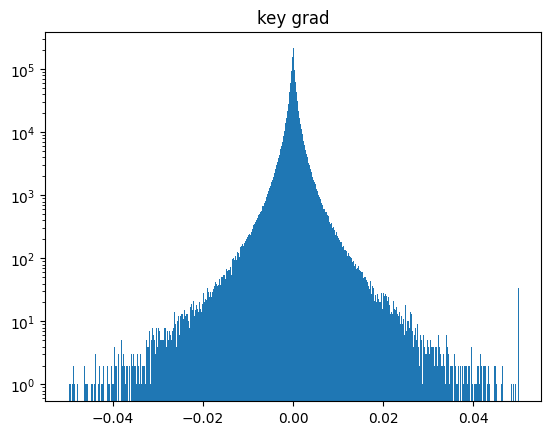

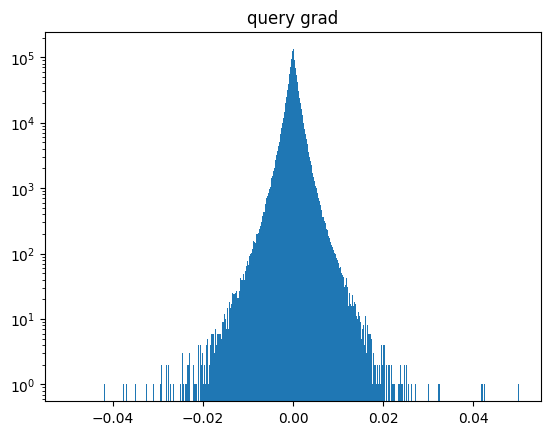

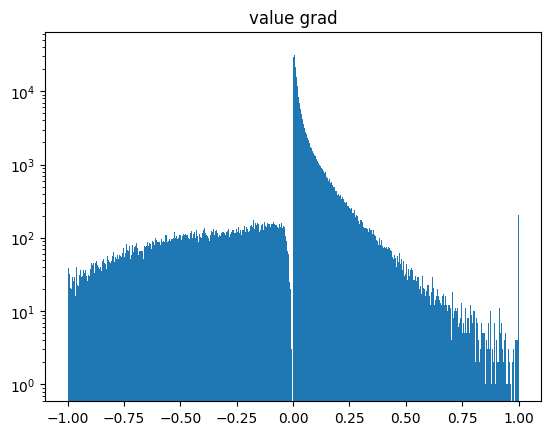

hist 



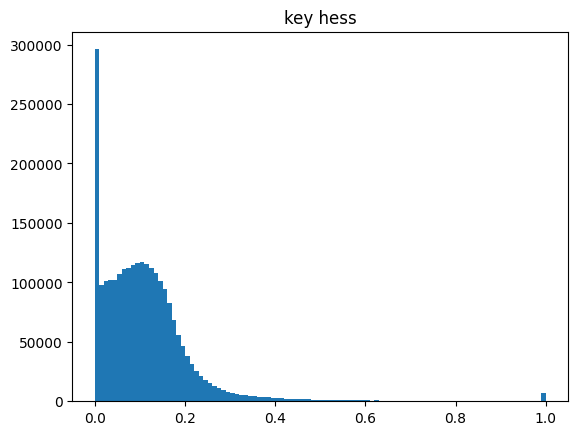

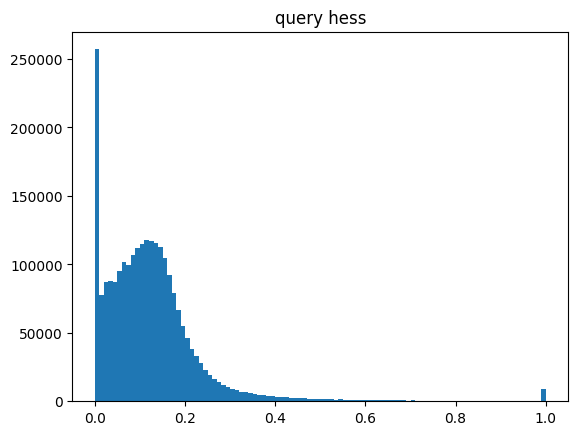

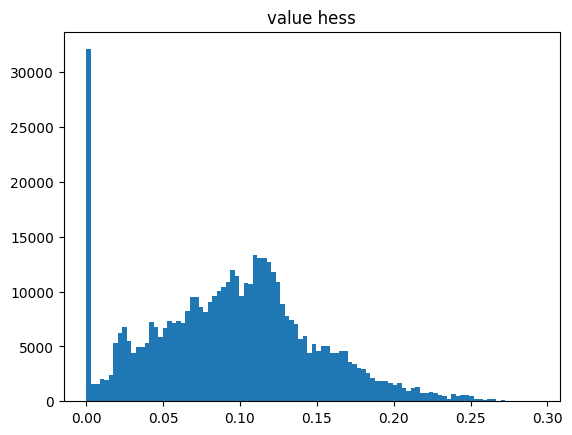

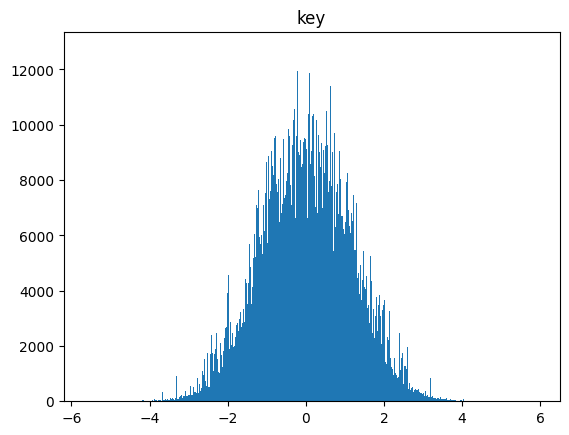

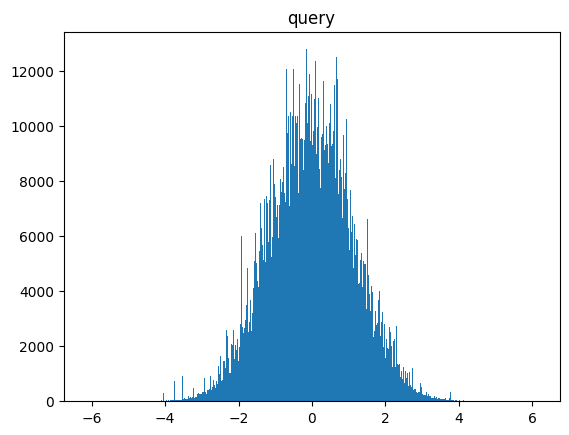

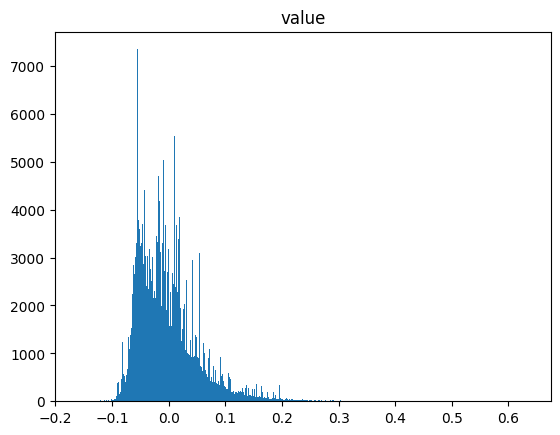

iteration 7 0.7688656616210937
iteration 8 0.7495425415039062
iteration 9 0.7080826416015625
iteration 10 0.6647863159179688
iteration 11 0.6580508422851562
iteration 12 0.6413037719726562
iteration 13 0.6402467041015625
iteration 14 0.5758077392578125
iteration 15 0.640259765625
iteration 16 0.6101278076171875
iteration 17 0.6083663940429688
iteration 18 0.55019482421875
iteration 19 0.545249267578125
iteration 20 0.554290283203125
iteration 21 0.612375732421875
iteration 22 0.5835916137695313
iteration 23 0.5393709716796875
iteration 24 0.54974560546875
iteration 25 0.5456537475585937
iteration 26 0.5289736938476562
iteration 27 0.556644287109375
iteration 28 0.5319058837890625
iteration 29 0.5310799560546875
iteration 30 0.5356144409179687
iteration 31 0.5372139282226562
iteration 32 0.5279503784179688
iteration 33 0.543259521484375
iteration 34 0.5885181884765625
iteration 35 0.552558349609375
iteration 36 0.4940263977050781
iteration 37 0.5639385375976562
iteration 38 0.5326101074

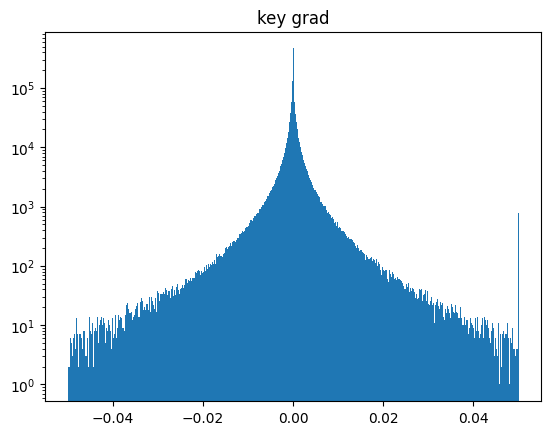

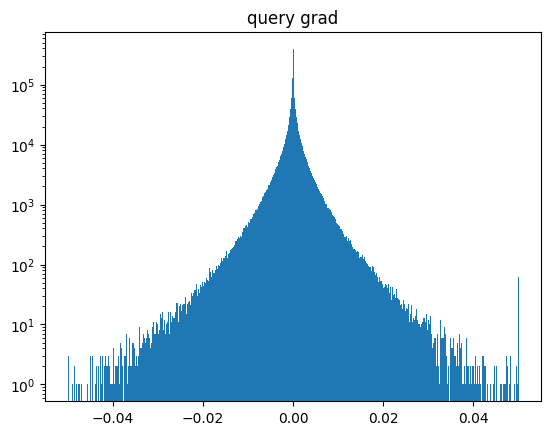

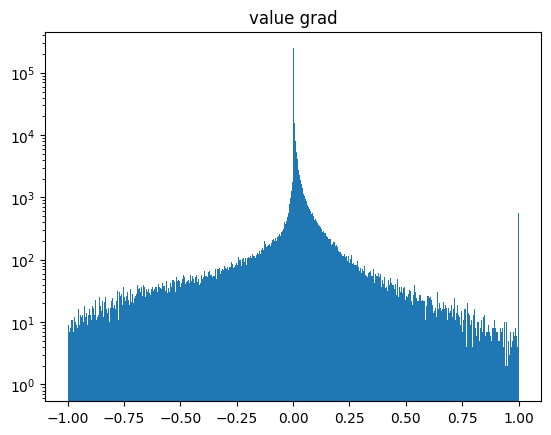

hist 



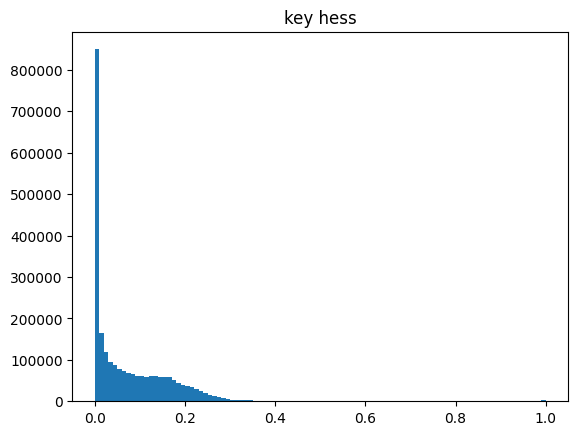

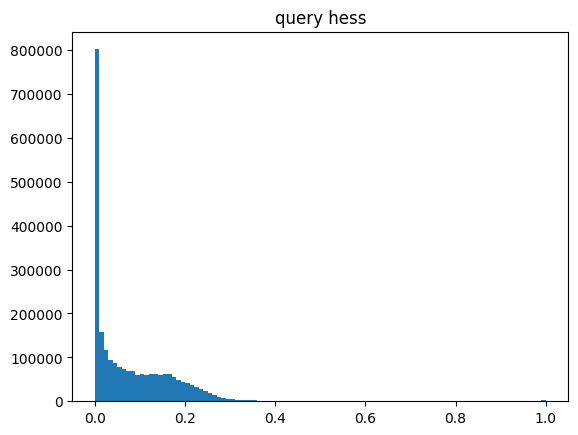

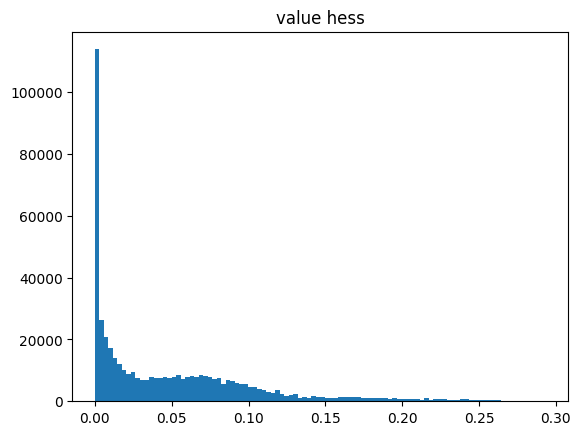

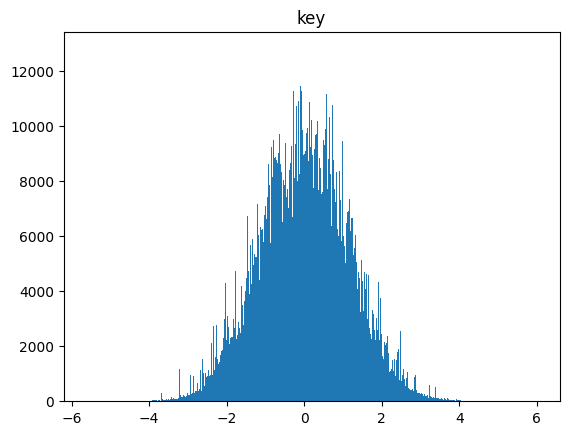

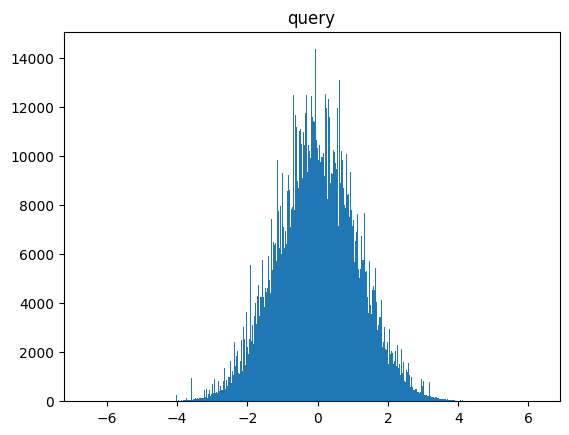

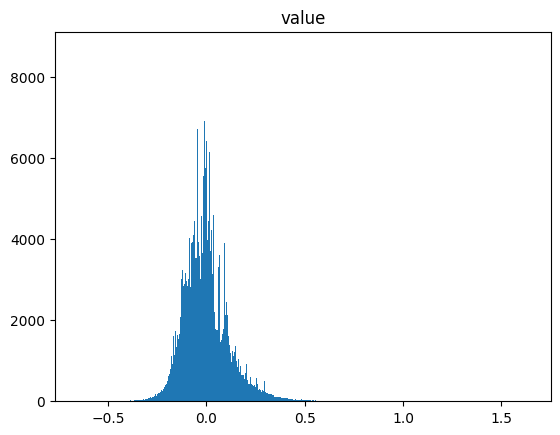

iteration 67 0.37979803466796874
iteration 68 0.38424887084960935
iteration 69 0.4580225830078125
iteration 70 0.4087254638671875
iteration 71 0.3830361328125
iteration 72 0.4284071350097656
iteration 73 0.3804167175292969
iteration 74 0.38774163818359375
iteration 75 0.42523681640625
iteration 76 0.38735604858398437
iteration 77 0.4473079833984375
iteration 78 0.43724374389648435
iteration 79 0.4100035705566406
iteration 80 0.401418701171875
iteration 81 0.4198310546875
iteration 82 0.433202880859375
iteration 83 0.422999267578125
iteration 84 0.3844327087402344
iteration 85 0.3926474609375
iteration 86 0.4840029296875
iteration 87 0.3527401428222656
iteration 88 0.4042718200683594
iteration 89 0.4255933532714844
iteration 90 0.3781859130859375
iteration 91 0.42486578369140626
iteration 92 0.3860029296875
iteration 93 0.40335330200195313
iteration 94 0.46041476440429685
iteration 95 0.3761813354492187
iteration 96 0.43865203857421875
iteration 97 0.3782050170898438
iteration 98 0.3787

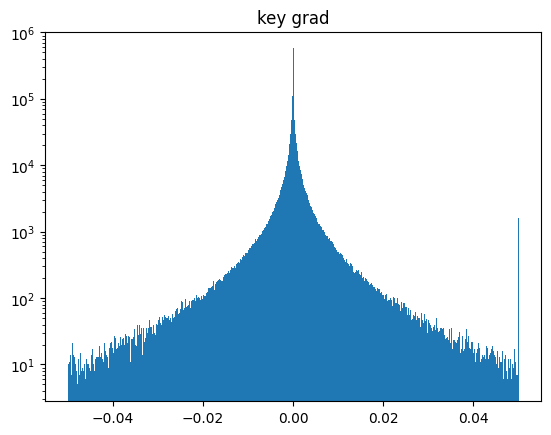

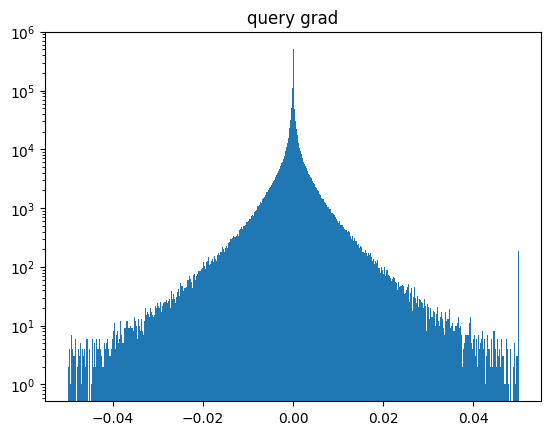

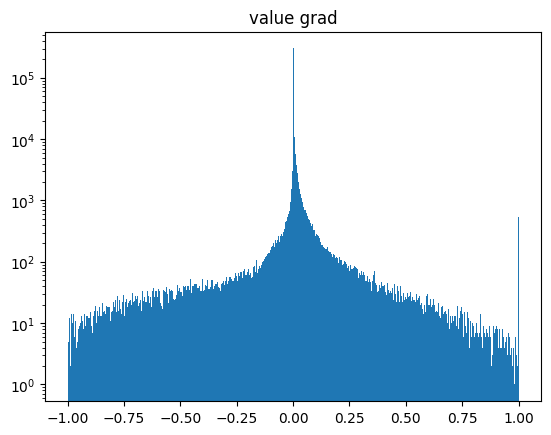

hist 



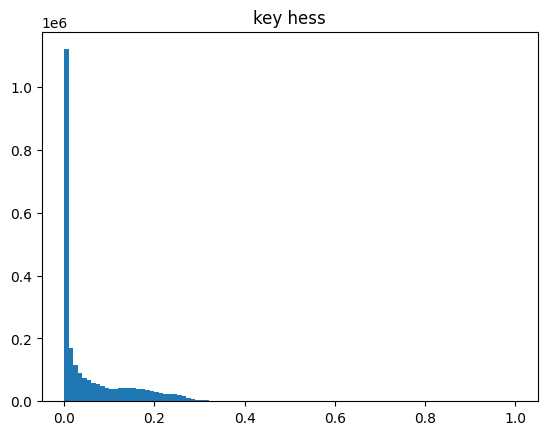

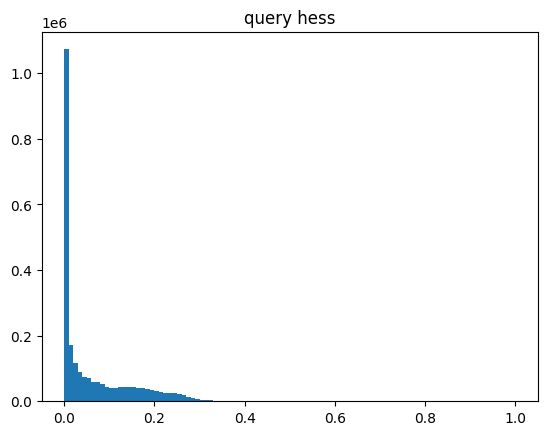

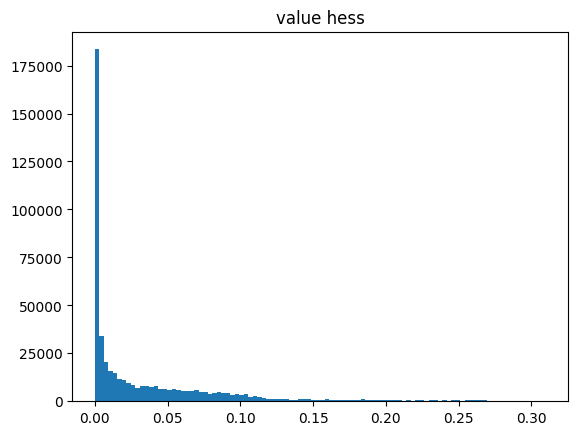

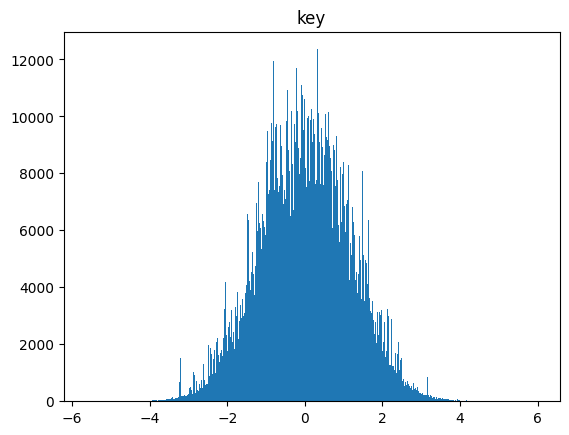

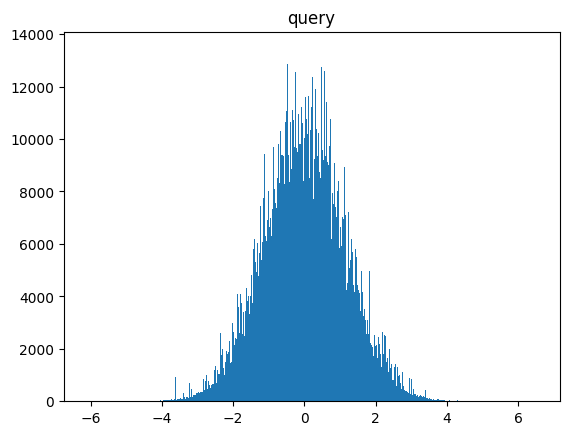

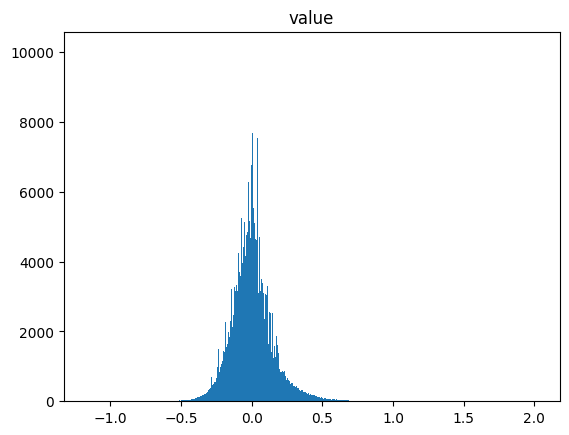

iteration 127 0.3466844482421875
iteration 128 0.3150198974609375
iteration 129 0.33193853759765624
iteration 130 0.3152938232421875
iteration 131 0.3306474304199219
iteration 132 0.34314584350585936
iteration 133 0.34537725830078125
iteration 134 0.29932684326171877
iteration 135 0.3215963134765625
iteration 136 0.35058389282226565
iteration 137 0.312180419921875
iteration 138 0.31205331420898436
iteration 139 0.33079669189453126
iteration 140 0.35116583251953126
iteration 141 0.34291064453125
iteration 142 0.3329798583984375
iteration 143 0.3251701049804688
iteration 144 0.32680682373046877
iteration 145 0.3181069030761719
iteration 146 0.371038330078125
iteration 147 0.3205867919921875
iteration 148 0.3436175537109375
iteration 149 0.32088662719726563
iteration 150 0.3309908752441406
iteration 151 0.3055084533691406
iteration 152 0.35406610107421876
iteration 153 0.31648519897460936
iteration 154 0.32702658081054686
iteration 155 0.3427644958496094
iteration 156 0.3069659729003906
i

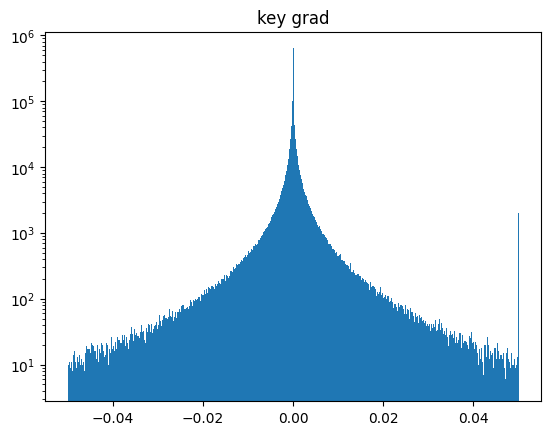

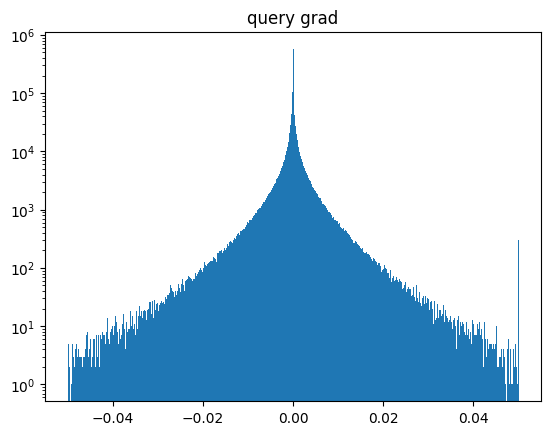

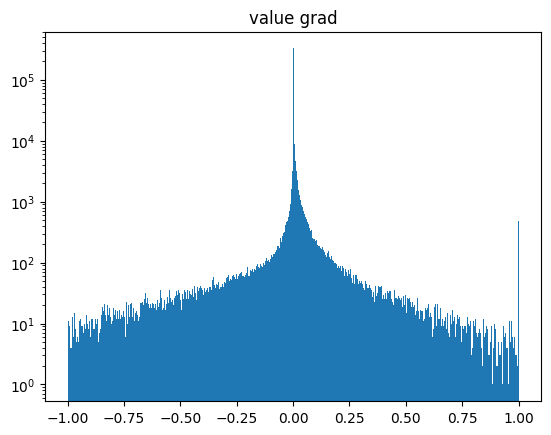

hist 



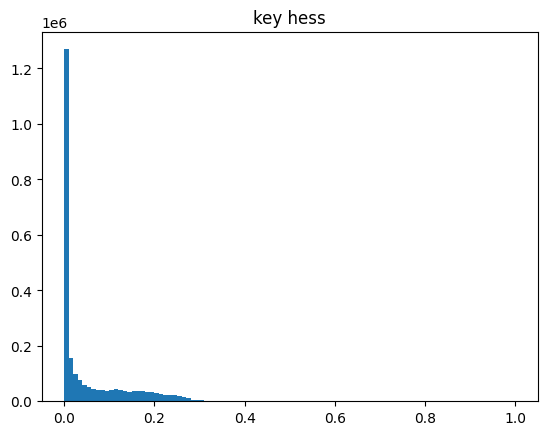

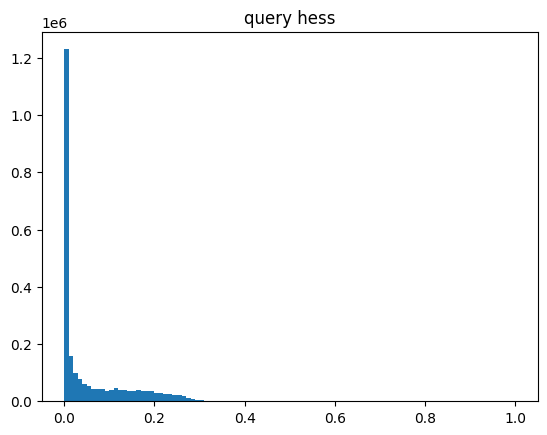

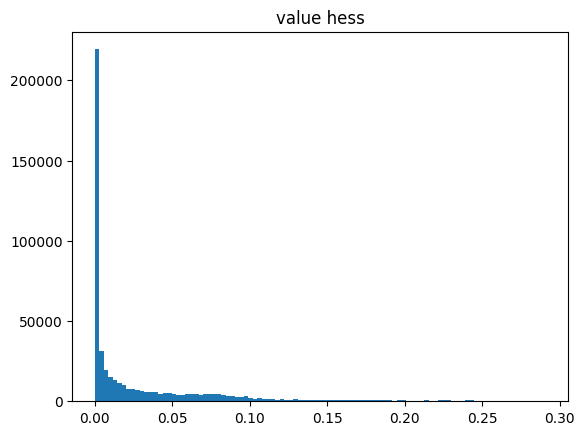

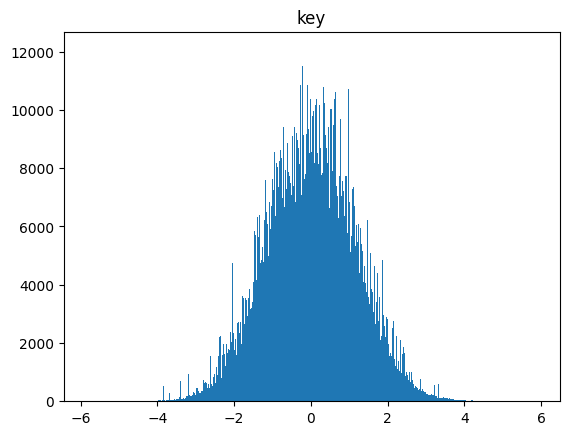

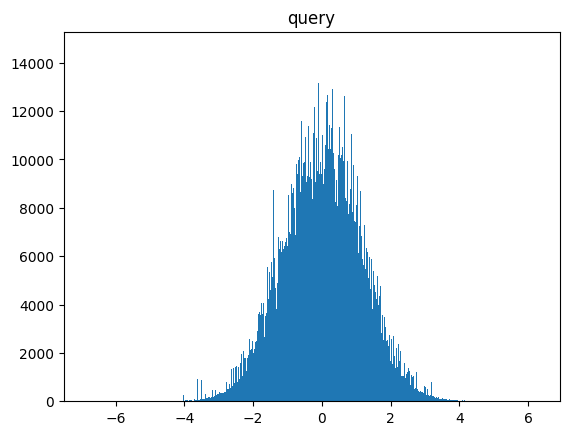

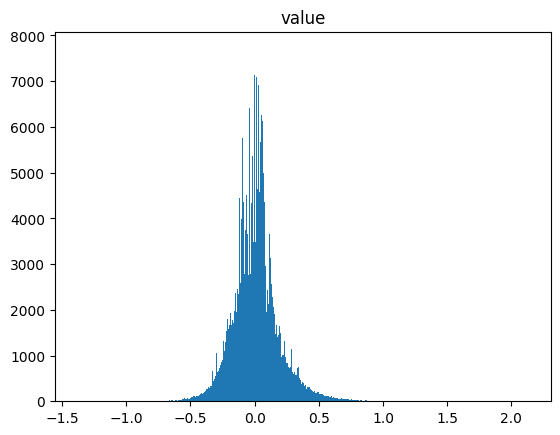

iteration 187 0.24393464660644532
iteration 188 0.27173056030273435
iteration 189 0.29192471313476565
iteration 190 0.24729353332519532
iteration 191 0.2357799835205078
iteration 192 0.24742303466796875
iteration 193 0.2906342468261719
iteration 194 0.2638081970214844
iteration 195 0.2960624084472656
iteration 196 0.2466417694091797
iteration 197 0.26190997314453124
iteration 198 0.2606188659667969
iteration 199 0.2883169250488281
iteration 200 0.26023077392578126
iteration 201 0.263525634765625
iteration 202 0.27527145385742186
iteration 203 0.2846578369140625
iteration 204 0.24687742614746094
iteration 205 0.26921279907226564
iteration 206 0.289434814453125
iteration 207 0.26101882934570314
iteration 208 0.2734299011230469
iteration 209 0.28870062255859374
iteration 210 0.2922098693847656
iteration 211 0.27685089111328126
iteration 212 0.24095944213867188
iteration 213 0.2515762481689453
iteration 214 0.32996072387695313
iteration 215 0.3127081298828125
iteration 216 0.29704208374023

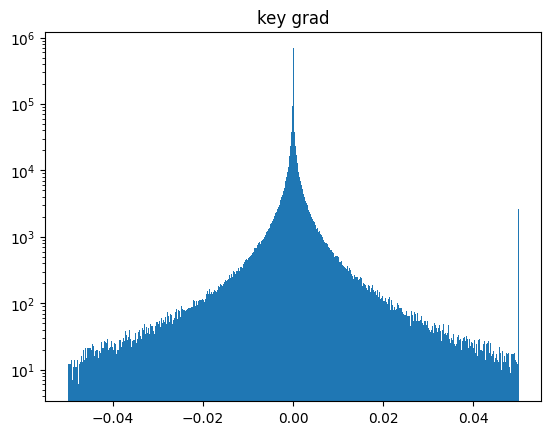

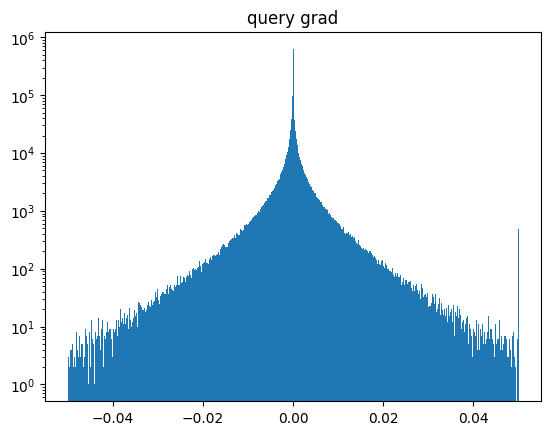

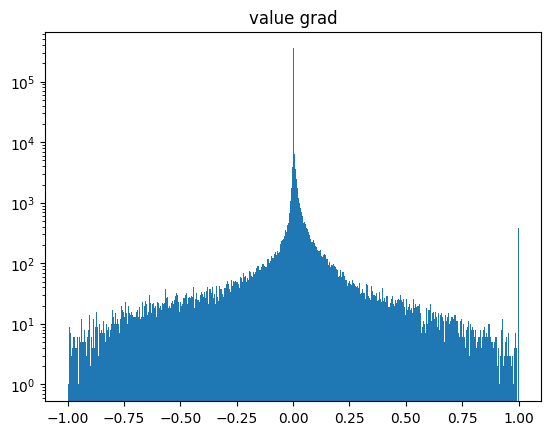

hist 



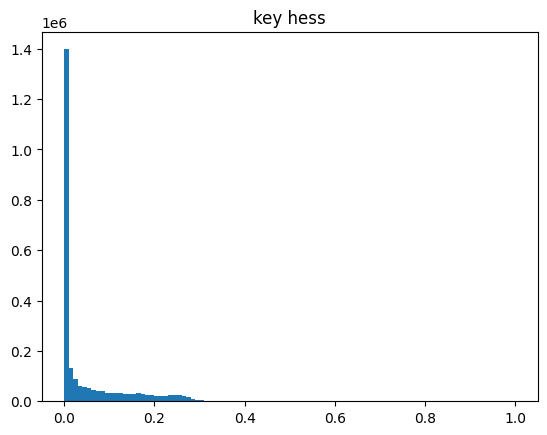

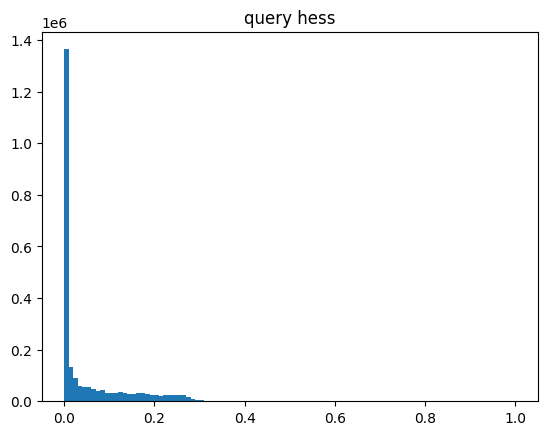

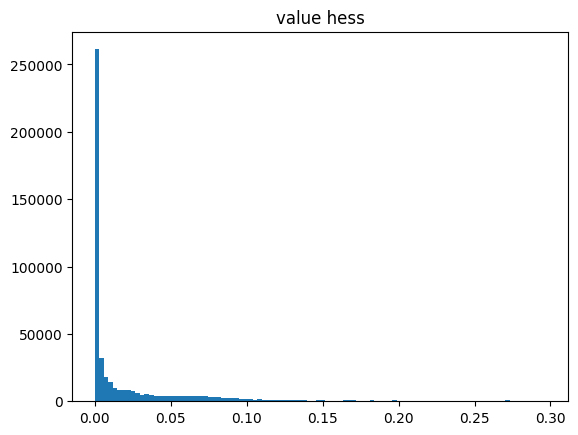

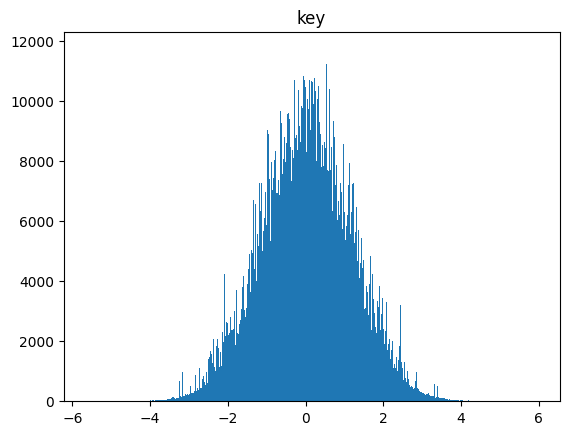

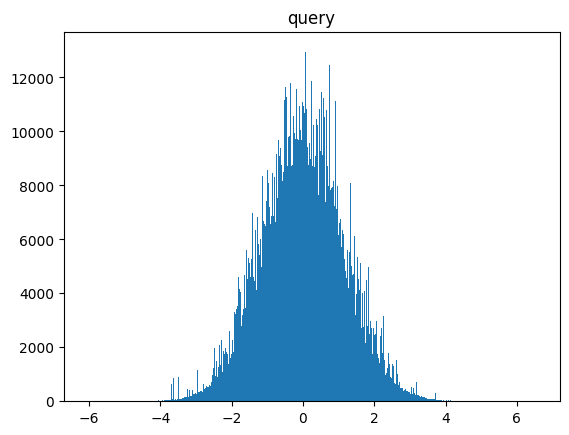

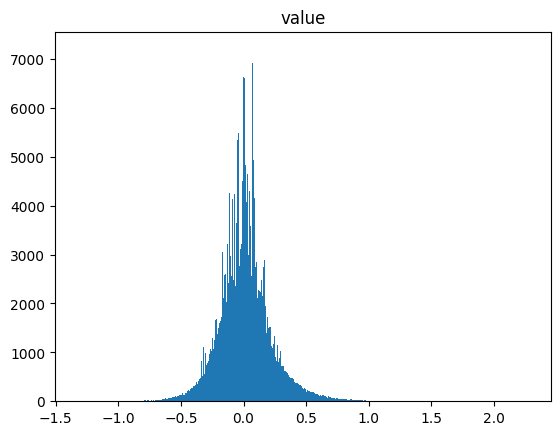

iteration 247 0.21461984252929686
iteration 248 0.20897445678710938
iteration 249 0.20414268493652343
iteration 250 0.20591737365722657
iteration 251 0.2136007537841797
iteration 252 0.24057450866699218
iteration 253 0.20507933044433593
iteration 254 0.22129898071289061
iteration 255 0.22965095520019532
iteration 256 0.19721954345703124
iteration 257 0.19113352966308594
iteration 258 0.23422119140625
iteration 259 0.20593392944335936
iteration 260 0.21252505493164062
iteration 261 0.21133824157714845
iteration 262 0.21798301696777345
iteration 263 0.25385557556152344
iteration 264 0.2326837615966797
iteration 265 0.2266573486328125
iteration 266 0.19871076965332032
iteration 267 0.21978176879882813
iteration 268 0.23486231994628906
iteration 269 0.23680410766601562
iteration 270 0.22082589721679688
iteration 271 0.2391163330078125
iteration 272 0.24252401733398438
iteration 273 0.2542328948974609
iteration 274 0.19752342224121094
iteration 275 0.21994976806640626
iteration 276 0.240526

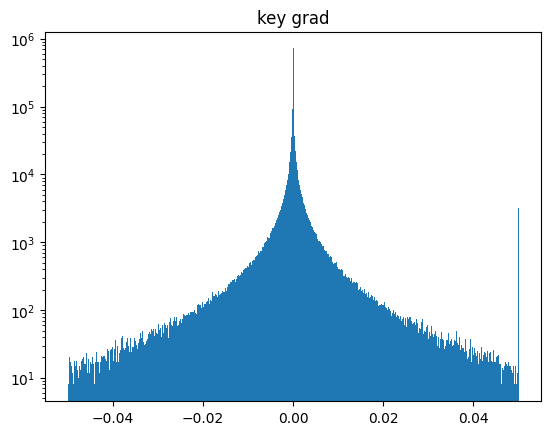

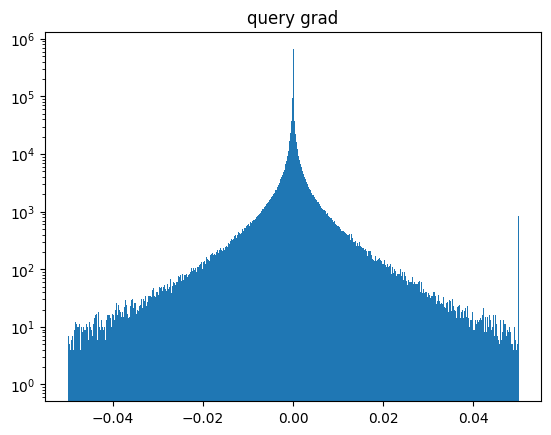

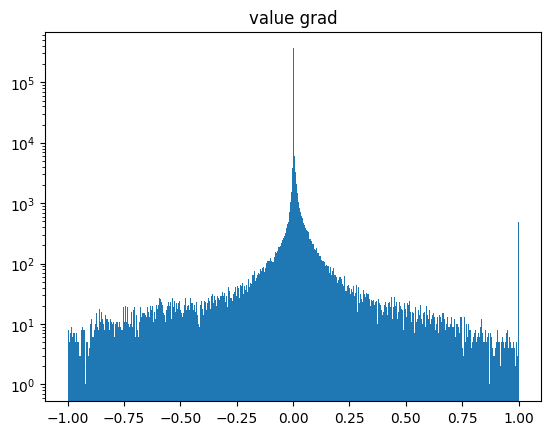

hist 



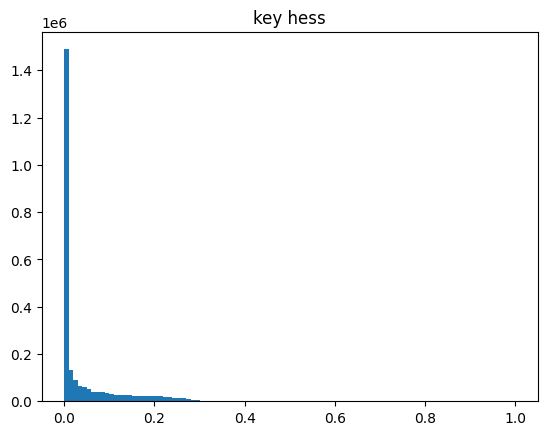

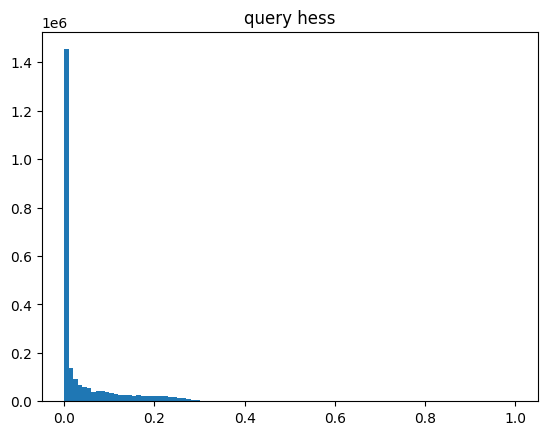

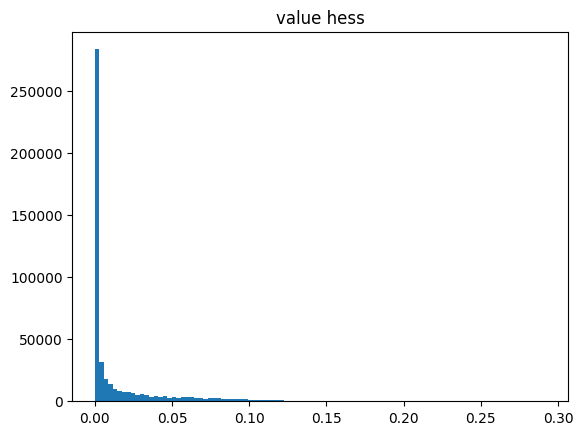

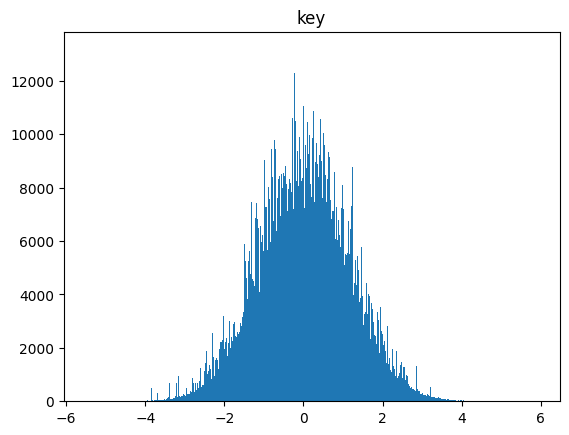

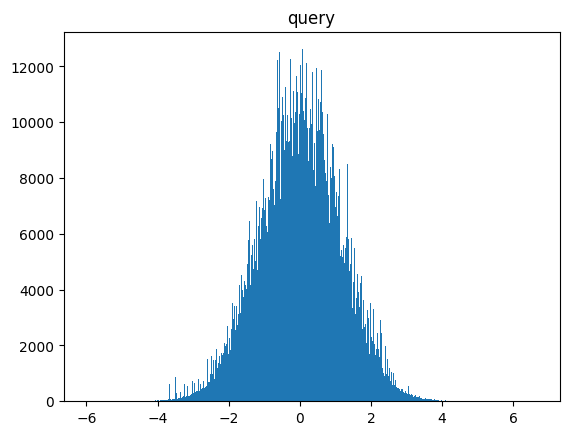

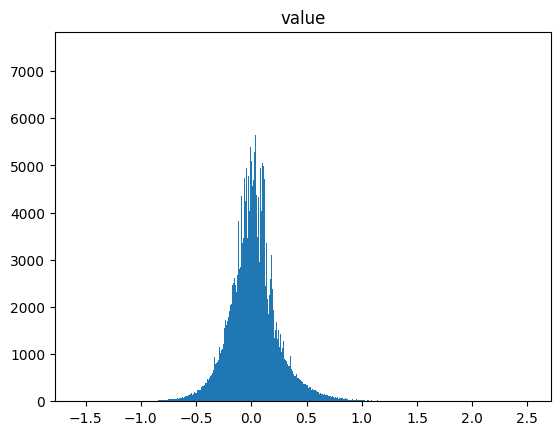

iteration 307 0.1630955810546875
iteration 308 0.1760452423095703
iteration 309 0.17761842346191406
iteration 310 0.18659500122070313
iteration 311 0.17626467895507814
iteration 312 0.1648664093017578
iteration 313 0.1690137939453125
iteration 314 0.20233644104003906
iteration 315 0.19381942749023437
iteration 316 0.1869378204345703
iteration 317 0.17682774353027345
iteration 318 0.15796418762207032
iteration 319 0.19749168395996095
iteration 320 0.18493919372558593
iteration 321 0.17149494934082032
iteration 322 0.18687608337402345
iteration 323 0.1600281524658203
iteration 324 0.18081047058105468
iteration 325 0.213263671875
iteration 326 0.20887831115722658
iteration 327 0.22552268981933593
iteration 328 0.21262626647949218
iteration 329 0.17133258056640624
iteration 330 0.20586477661132813
iteration 331 0.21269723510742186
iteration 332 0.17841079711914062
iteration 333 0.16609632873535157
iteration 334 0.1918318634033203
iteration 335 0.18903932189941405
iteration 336 0.2260619049

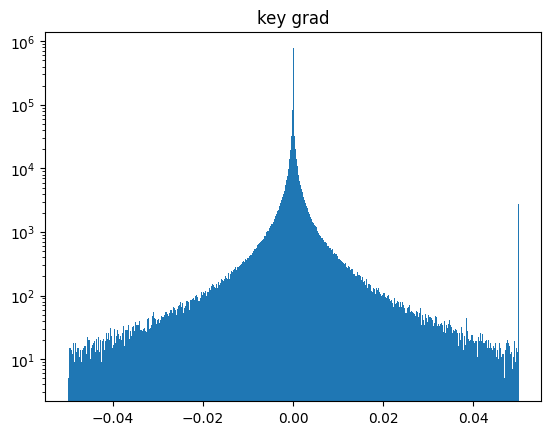

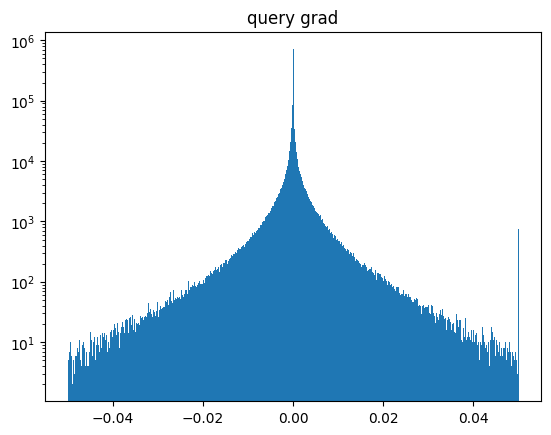

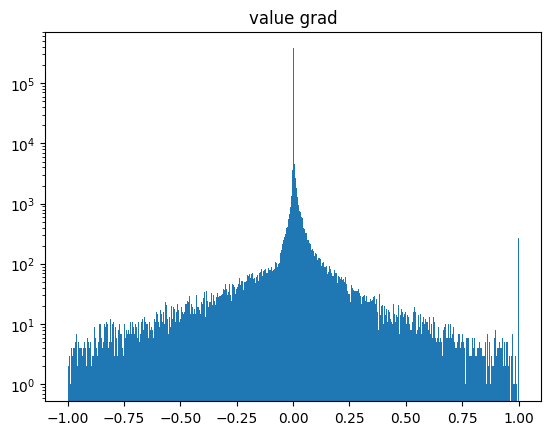

hist 



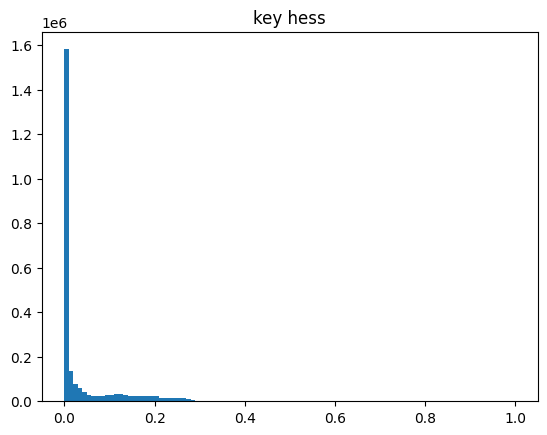

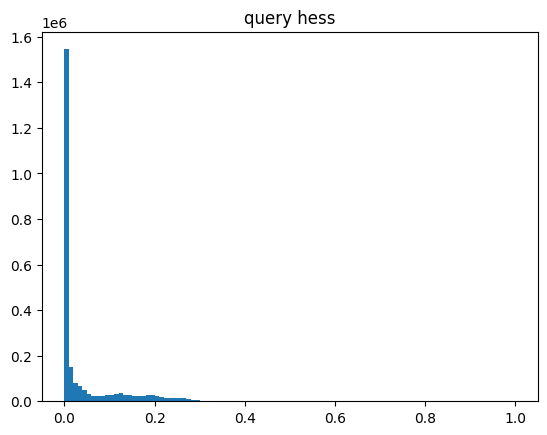

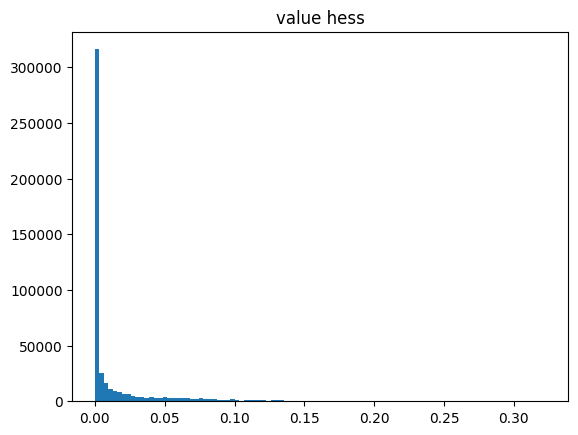

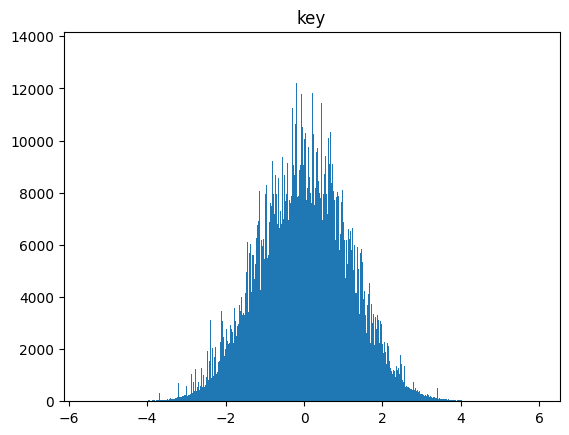

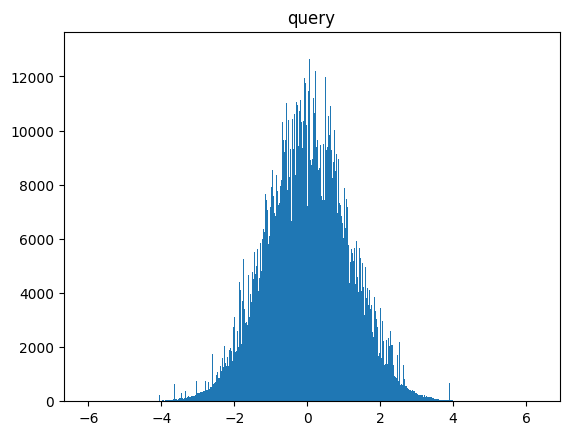

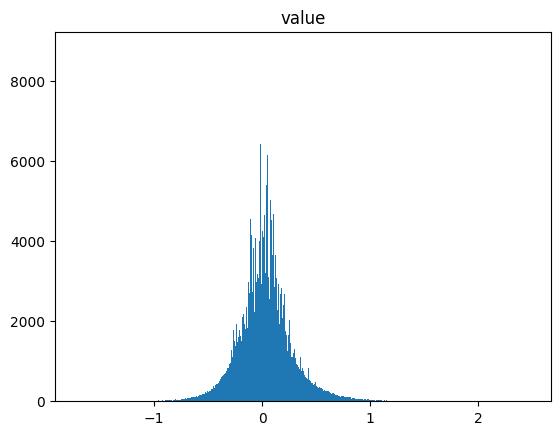

iteration 367 0.13351373291015625
iteration 368 0.147549072265625
iteration 369 0.16647517395019532
iteration 370 0.13864576721191407
iteration 371 0.1520439453125
iteration 372 0.17259889221191407
iteration 373 0.14908497619628908
iteration 374 0.12811367797851564
iteration 375 0.15702516174316405
iteration 376 0.12854536437988281
iteration 377 0.1782554931640625
iteration 378 0.17477490234375
iteration 379 0.1516027374267578
iteration 380 0.1374343566894531
iteration 381 0.14552162170410157
iteration 382 0.16167701721191408
iteration 383 0.17181967163085937
iteration 384 0.15675334167480467
iteration 385 0.17006243896484374
iteration 386 0.15366070556640626
iteration 387 0.16905763244628907
iteration 388 0.1871436004638672
iteration 389 0.13252381896972656
iteration 390 0.15065660095214845
iteration 391 0.13916082763671875
iteration 392 0.17305482482910156
iteration 393 0.18015670776367188
iteration 394 0.20819500732421875
iteration 395 0.16404444885253905
iteration 396 0.17338795471

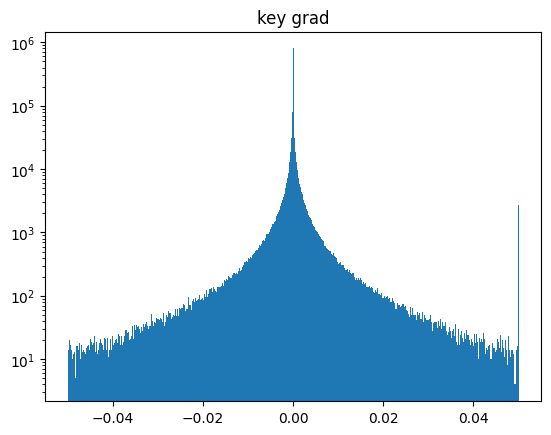

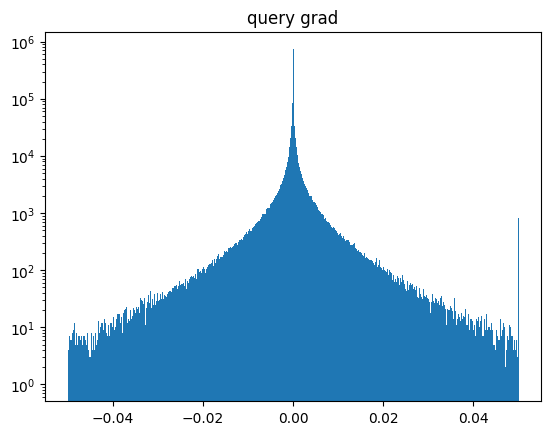

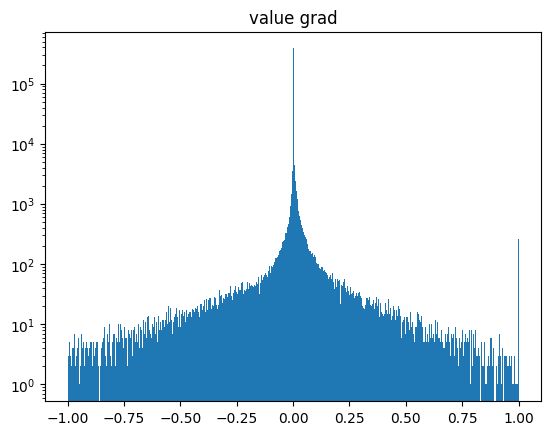

hist 



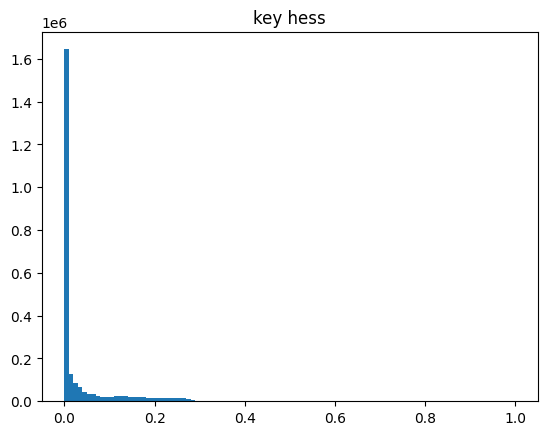

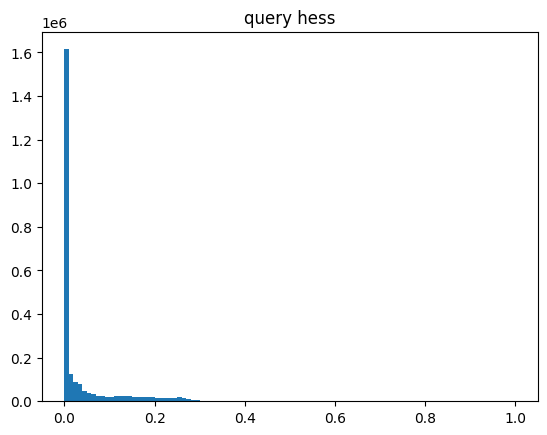

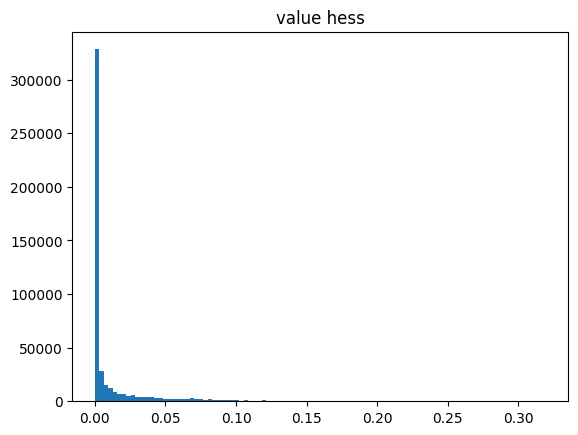

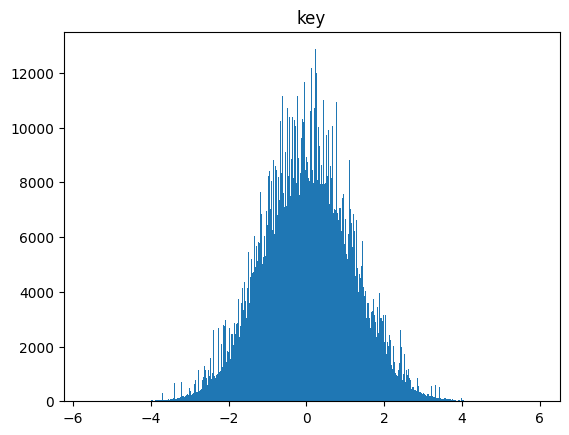

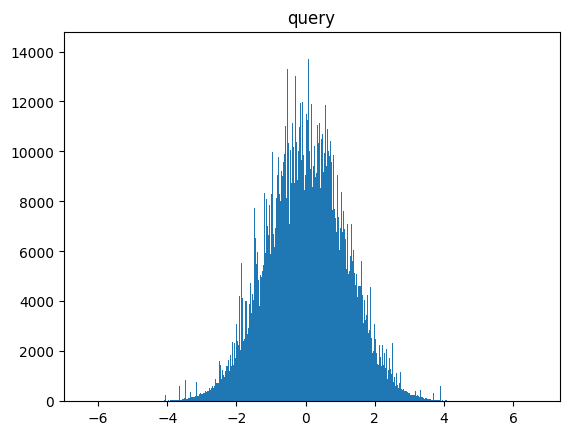

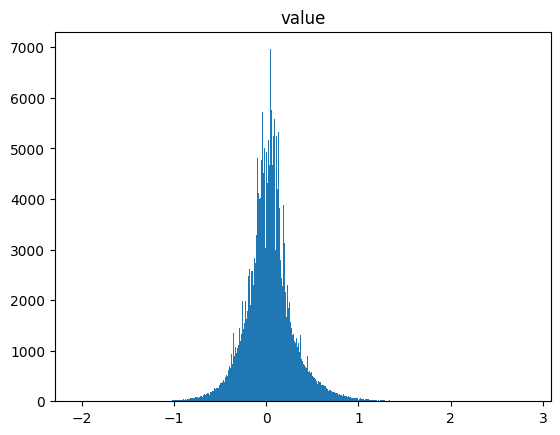

iteration 427 0.1120169677734375
iteration 428 0.12405020141601562
iteration 429 0.10515576171875
iteration 430 0.11249810028076172
iteration 431 0.1143782958984375
iteration 432 0.1341233673095703
iteration 433 0.1507602081298828
iteration 434 0.12338634490966797
iteration 435 0.14781927490234376
iteration 436 0.12028060913085938
iteration 437 0.11669522857666016
iteration 438 0.11718834686279297
iteration 439 0.11352835845947265
iteration 440 0.12458889007568359
iteration 441 0.1498393249511719
iteration 442 0.13864149475097656
iteration 443 0.13841015625
iteration 444 0.1553643035888672
iteration 445 0.1611624755859375
iteration 446 0.11194352722167969
iteration 447 0.12795313262939453
iteration 448 0.12655165100097657
iteration 449 0.1111563720703125
iteration 450 0.11970012664794921
iteration 451 0.1302136688232422
iteration 452 0.1326195831298828
iteration 453 0.11981099700927735
iteration 454 0.1124810791015625
iteration 455 0.13363119506835938
iteration 456 0.13596611022949218


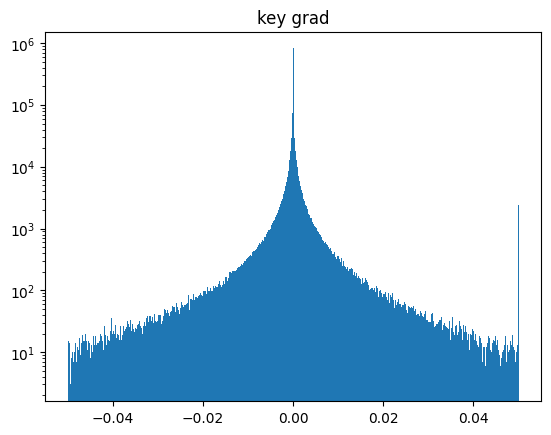

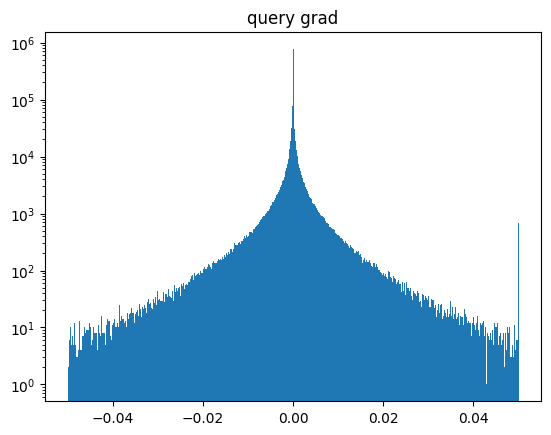

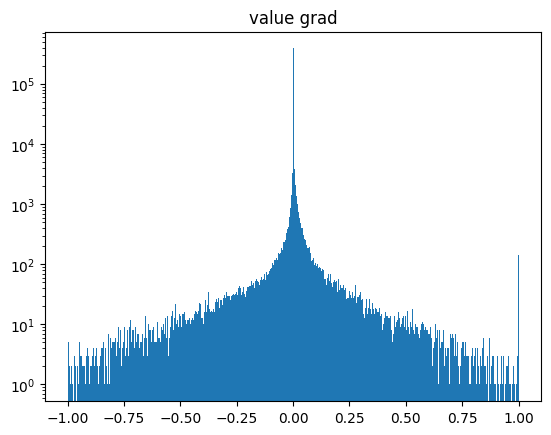

hist 



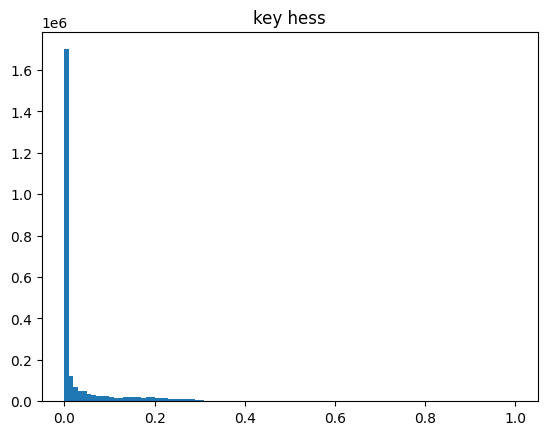

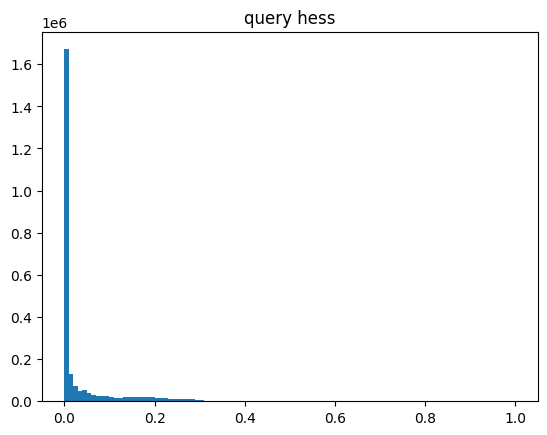

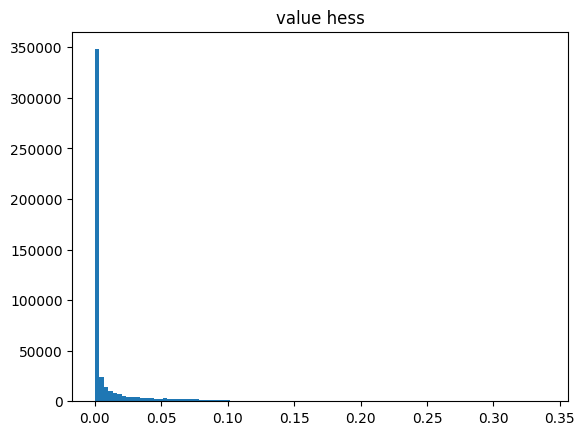

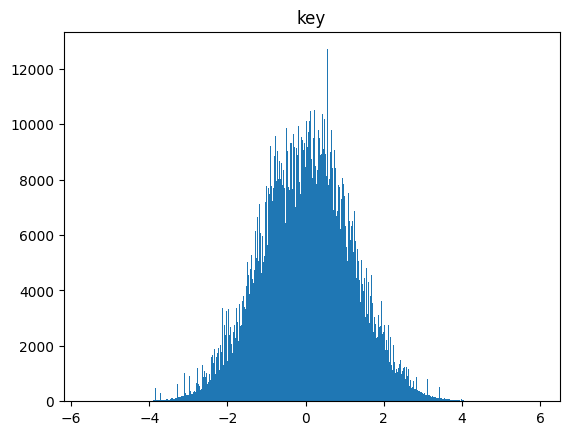

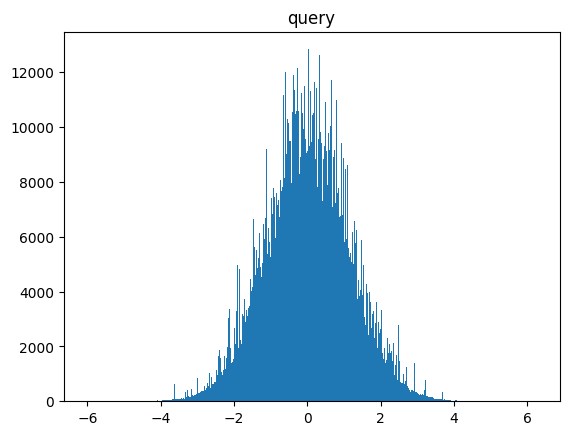

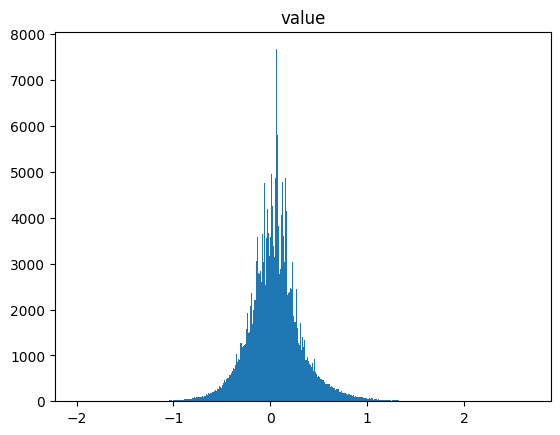

iteration 487 0.08478265380859375
iteration 488 0.10664006042480469
iteration 489 0.09729024505615234
iteration 490 0.08761968994140625
iteration 491 0.10576315307617187
iteration 492 0.08766242218017578
iteration 493 0.10287532043457032
iteration 494 0.07372834014892578
iteration 495 0.10773302459716796
iteration 496 0.11018976593017578
iteration 497 0.09289191436767578
iteration 498 0.09901175689697266
iteration 499 0.11406478881835938
iteration 500 0.09012931060791016
iteration 501 0.0920953369140625
iteration 502 0.10010449981689454
iteration 503 0.1037184829711914
iteration 504 0.1182221450805664
iteration 505 0.10228714752197265
iteration 506 0.09612366485595703
iteration 507 0.10278199768066407
iteration 508 0.092826416015625
iteration 509 0.08582898712158203
iteration 510 0.10574606323242187
iteration 511 0.09589175415039063
iteration 512 0.08806045532226563
iteration 513 0.126190673828125
iteration 514 0.10614833068847657
iteration 515 0.11805289459228516
iteration 516 0.10543

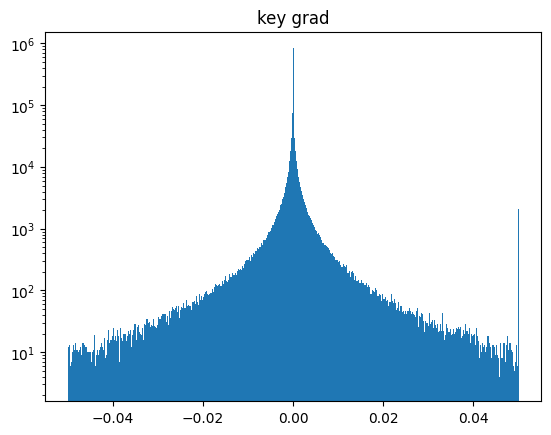

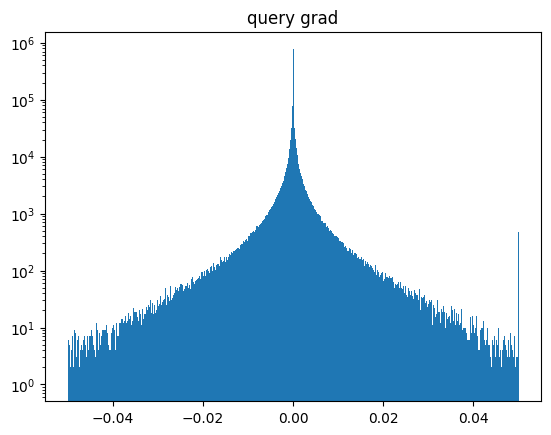

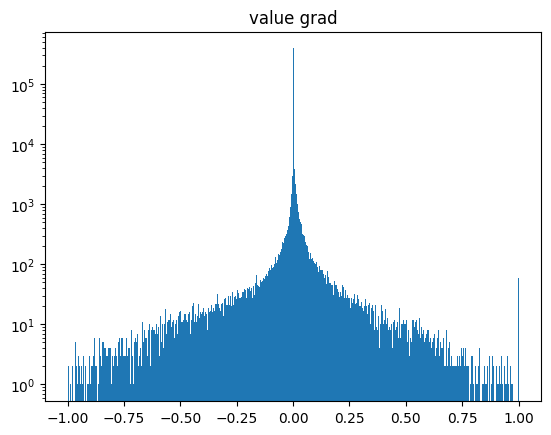

hist 



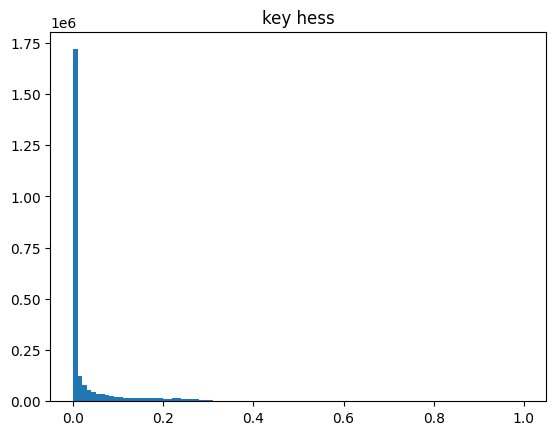

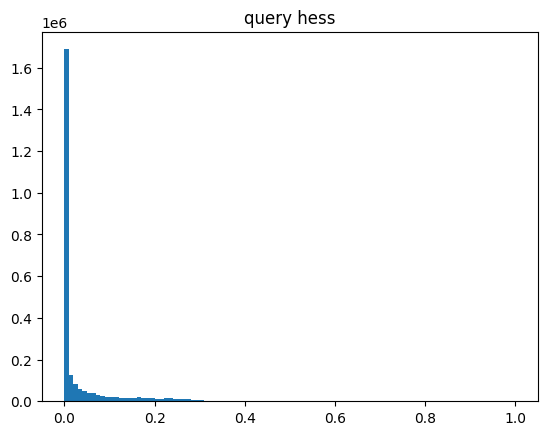

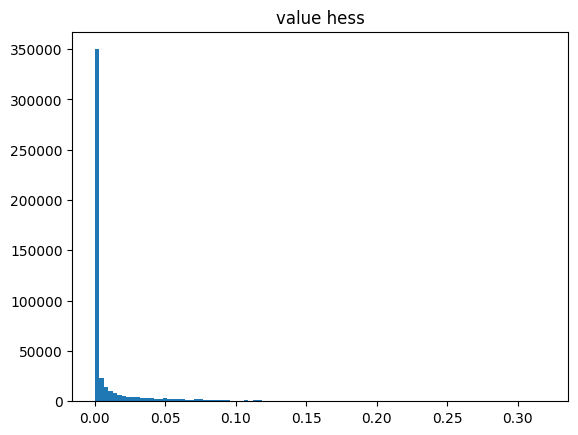

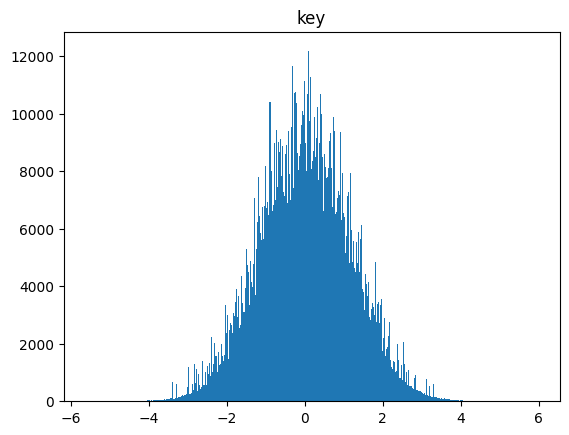

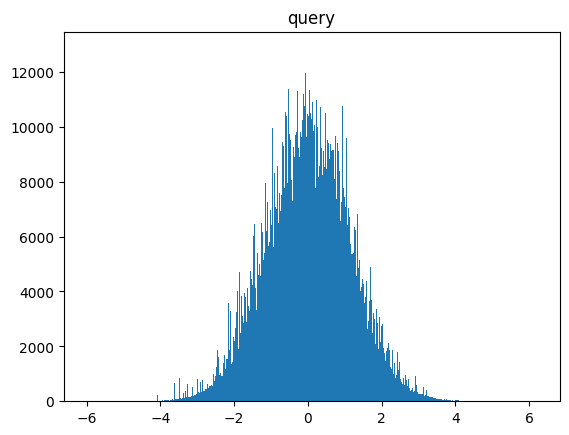

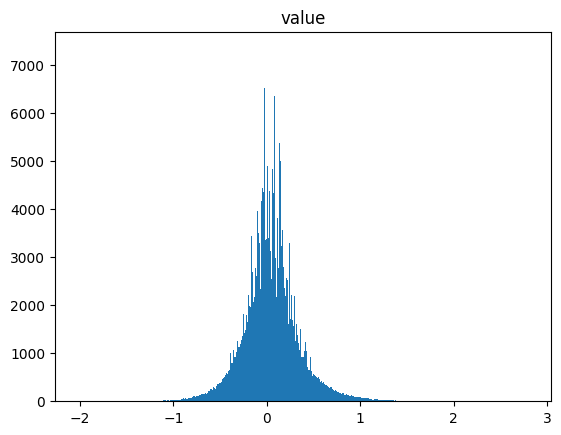

iteration 547 0.06386027145385742
iteration 548 0.07004514312744141
iteration 549 0.06906295776367187
iteration 550 0.07073733520507812
iteration 551 0.08139921569824218
iteration 552 0.0824012451171875
iteration 553 0.09006086730957032
iteration 554 0.08545955657958984
iteration 555 0.06331064987182618
iteration 556 0.07109920501708984
iteration 557 0.0807258071899414
iteration 558 0.06943939971923828
iteration 559 0.06501930236816406
iteration 560 0.0773381805419922
iteration 561 0.08755268096923828
iteration 562 0.08101274108886719
iteration 563 0.06668842315673829
iteration 564 0.0791470947265625
iteration 565 0.07585572814941406
iteration 566 0.08728760528564453
iteration 567 0.0854275131225586
iteration 568 0.0820383071899414
iteration 569 0.08392938995361328
iteration 570 0.08323008728027344
iteration 571 0.09495539093017578
iteration 572 0.0863082275390625
iteration 573 0.0908503646850586
iteration 574 0.07205850219726563
iteration 575 0.09401290130615235
iteration 576 0.078918

In [45]:
for epoch in range(10):
    for i, data in enumerate(TrainLoader):
        x , target = data['image_seq'] , data['label']
        model_XT = x.reshape(-1,input_dim)
        dtrain = xgb.DMatrix(model_XT.numpy())

        key = key_booster.predict(dtrain, output_margin=True)
        query = query_booster.predict(dtrain, output_margin=True)
        value = value_booster.predict(dtrain, output_margin=True)

        predicts, grad, hess, loss = predict(key, query, value)

        key_booster.boost(dtrain, grad["key"], hess["key"])
        query_booster.boost(dtrain, grad["query"], hess["query"])
        value_booster.boost(dtrain, grad["value"], hess["value"])
        it += 1
        print(f'iteration {it}' , loss/batch_size)
        if i == 5 :
            plot()
        # v_t = torch.zeros_like(torch.tensor(dummy_output))
        # m_t = torch.zeros_like(torch.tensor(dummy_output))
        
        
    # cm = test_cm()
    # t_cm = train_cm()


In [49]:
@torch.no_grad()
def confusion_score(dataloader):
    cm = None
    
    for i, data in enumerate(dataloader):
        x , target = data['image_seq'] , data['label']
        model_XT = x.reshape(-1,input_dim)
        dtrain = xgb.DMatrix(model_XT.numpy())

        key = key_booster.predict(dtrain, output_margin=True)
        query = query_booster.predict(dtrain, output_margin=True)
        value = value_booster.predict(dtrain, output_margin=True)
        predicts = predict(key, query, value, has_grad=False)
        yhat = predicts.argmax(dim=-1).numpy() 
        if cm is None:
            cm = confusion_matrix(target.numpy(),yhat)
        else:
            cm += confusion_matrix(target.numpy(),yhat)
    print('Acc.',cm.diagonal().sum()/len(dataloader.dataset)) 
    return cm


In [50]:
confusion_score(TrainLoader)

Acc. 0.9877


array([[5926,    1,    9,   12,    1,    0,   50,    0,    1,    0],
       [   3, 5979,    3,    9,    1,    0,    5,    0,    0,    0],
       [  19,    0, 5902,   16,   24,    0,   37,    0,    2,    0],
       [  32,    3,    7, 5907,   12,    0,   39,    0,    0,    0],
       [   7,    3,   45,   25, 5835,    0,   85,    0,    0,    0],
       [   0,    0,    0,    0,    0, 5983,    0,   14,    0,    3],
       [ 117,    0,   45,   16,   24,    0, 5795,    0,    3,    0],
       [   0,    0,    0,    0,    0,    8,    0, 5969,    0,   23],
       [   7,    2,    0,    4,    0,    2,    4,    0, 5980,    1],
       [   0,    0,    0,    0,    0,    1,    0,   13,    0, 5986]])

In [51]:
confusion_score(TestLoader)

Acc. 0.8385


array([[790,   1,  32,  37,   6,   1, 123,   0,  10,   0],
       [  3, 955,   8,  23,   3,   0,   5,   0,   3,   0],
       [ 24,   1, 754,  12,  93,   0, 110,   0,   6,   0],
       [ 37,   7,  23, 835,  34,   1,  60,   0,   3,   0],
       [  9,   0, 109,  39, 705,   1, 130,   0,   7,   0],
       [  0,   0,   0,   2,   0, 944,   1,  33,   4,  16],
       [154,   4, 100,  35, 103,   0, 584,   0,  20,   0],
       [  0,   0,   0,   0,   0,  14,   0, 933,   0,  53],
       [  6,   1,   9,   5,   4,   7,  17,   3, 946,   2],
       [  2,   0,   0,   0,   0,   8,   3,  46,   2, 939]])

In [38]:
# ic(model.num_boosted_rounds())
# model.save_model('softmax-att.json')

In [52]:
b = 0
all_test_preds = []
all_test_labels = []
all_model_outputs = []

for i, data in enumerate(TestLoader):
    print(i)
    x , target = data['image_seq'] , data['label']
    model_XT = x.reshape(-1,input_dim)
    
    dtrain = xgb.DMatrix(model_XT.numpy())
    
    key = key_booster.predict(dtrain, output_margin=True)
    query = query_booster.predict(dtrain, output_margin=True)
    value = value_booster.predict(dtrain, output_margin=True)
    with torch.no_grad():
        predicts = predict(key, query, value, has_grad=False)
    all_model_outputs.append(np.concatenate([value, key, query], axis=-1))
    yhat = predicts.argmax(dim=-1).numpy()
    all_test_preds.append(yhat)
    all_test_labels.append(target.numpy())
    break


preds = np.concatenate(all_test_preds)
labels = np.concatenate(all_test_labels)
model_outputs_test = np.concatenate(all_model_outputs)

0


In [53]:
t=10

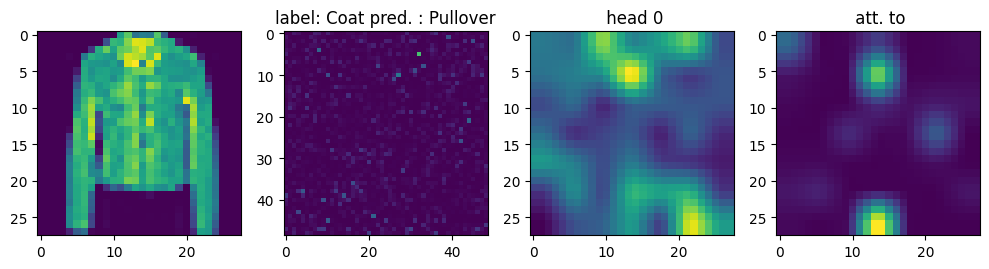

ic| t: 10


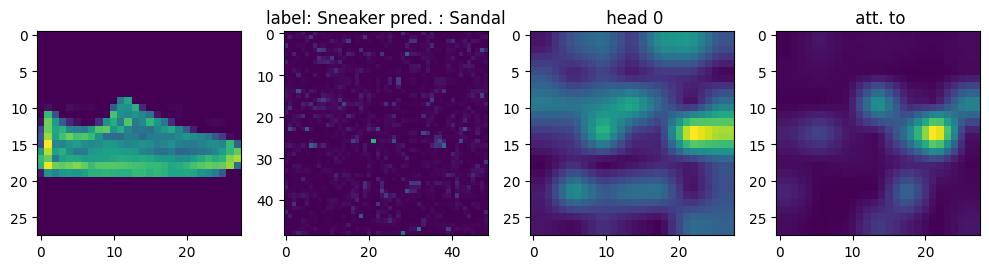

ic| t: 12


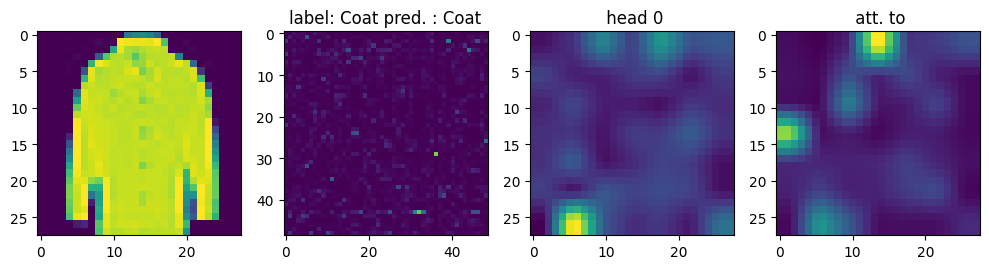

ic| t: 14


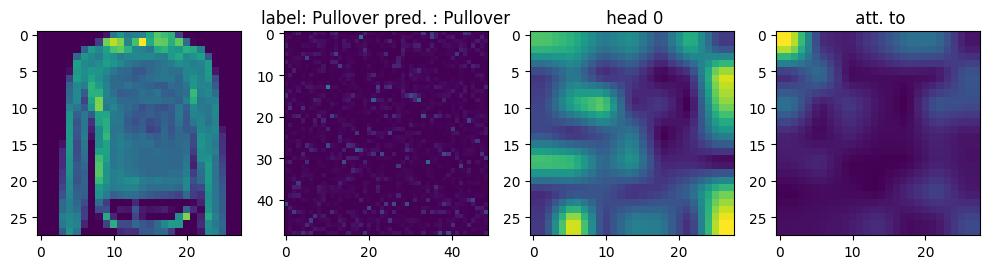

ic| t: 16


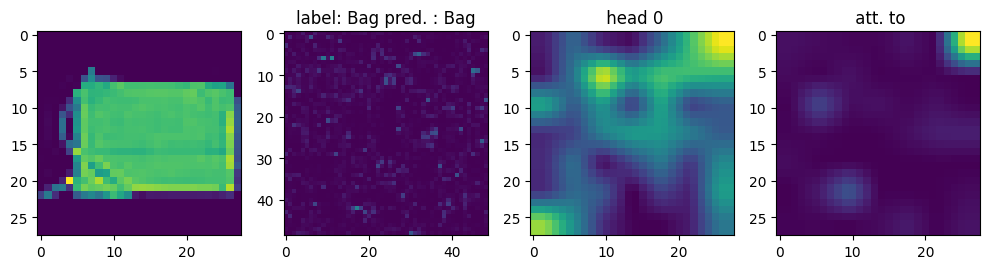

ic| t: 18


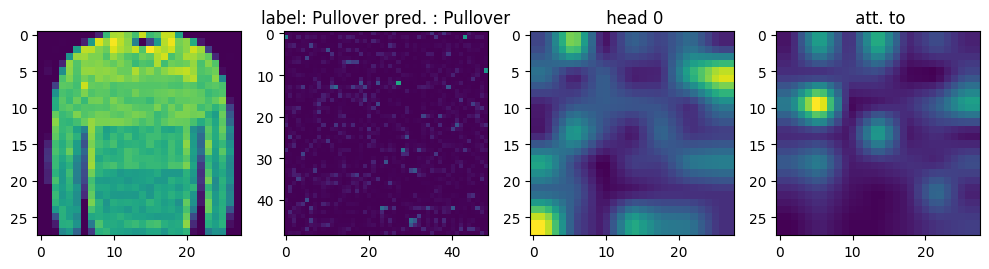

ic| t: 20


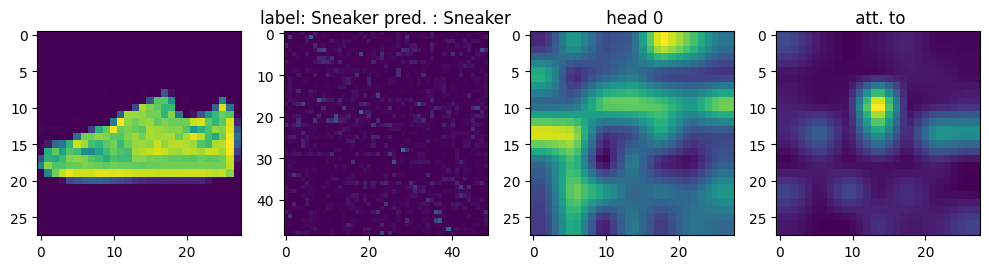

ic| t: 22


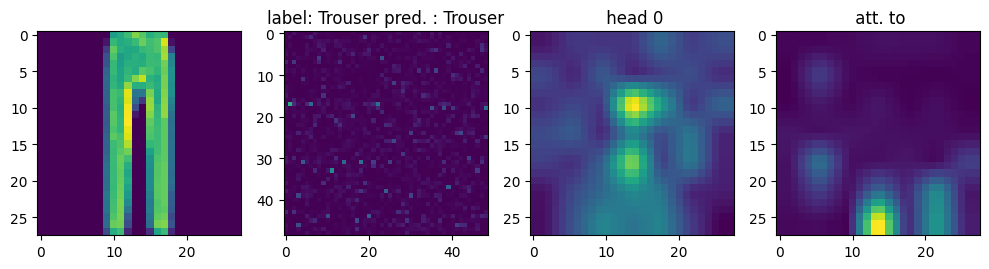

ic| t: 24


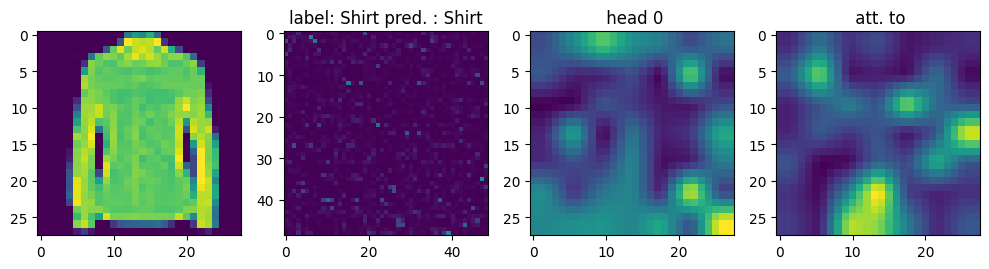

ic| t: 26


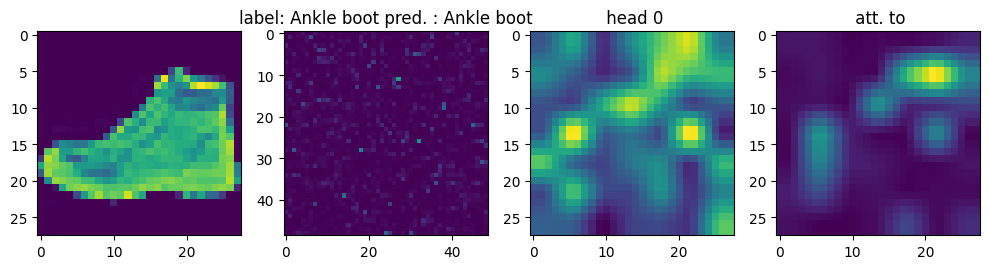

ic| t: 28


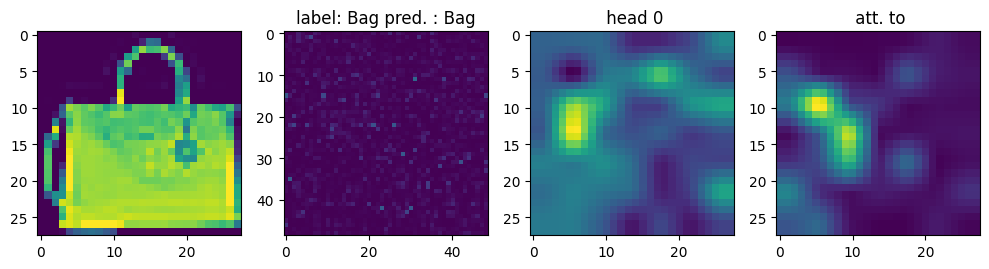

ic| t: 30


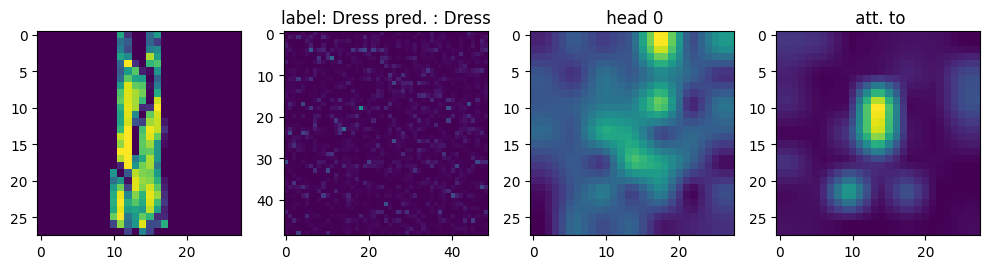

ic| t: 32


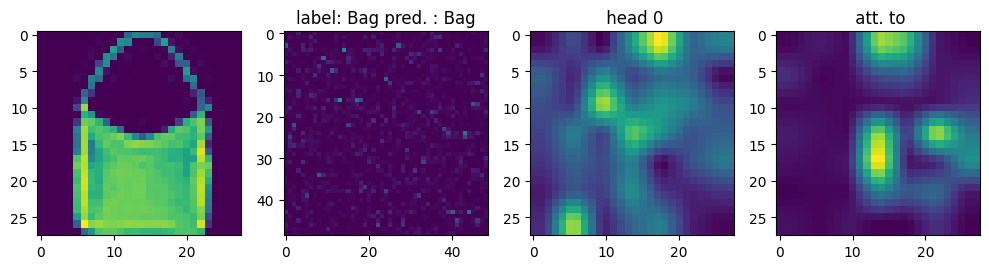

ic| t: 34


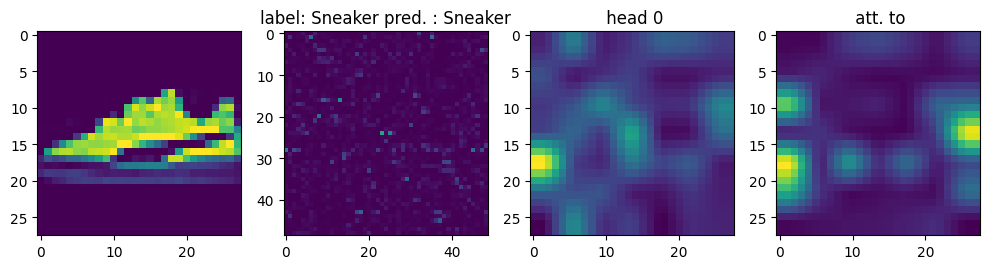

ic| t: 36


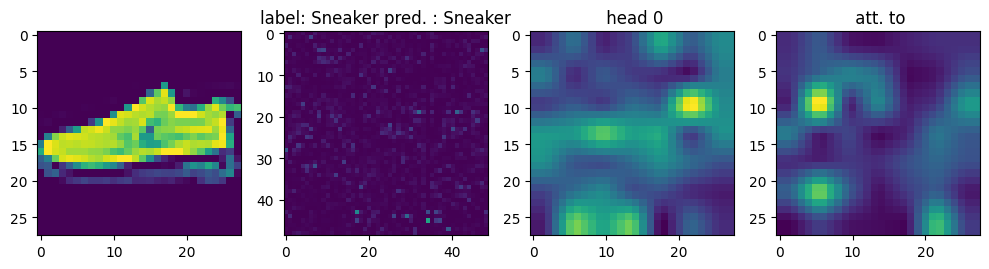

ic| t: 38


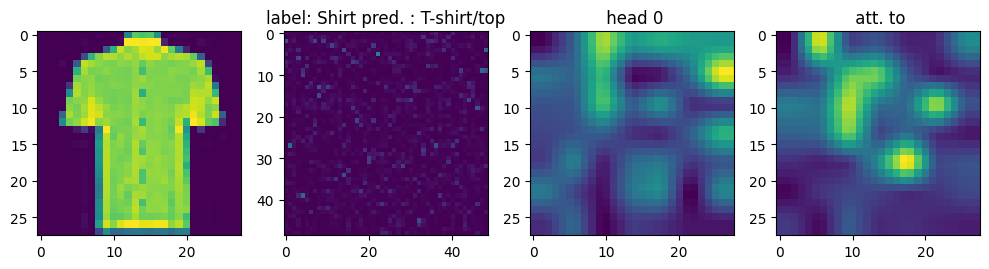

ic| t: 40


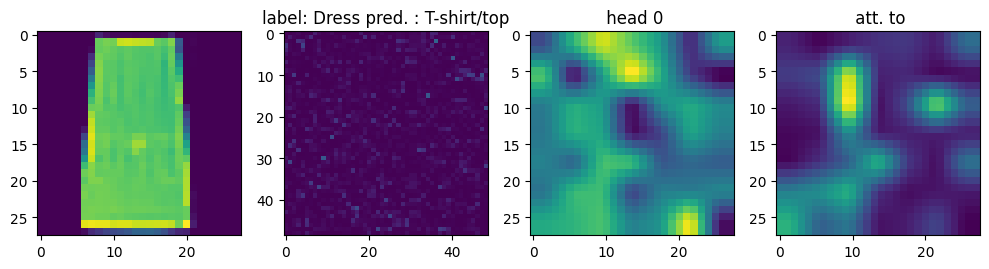

ic| t: 42


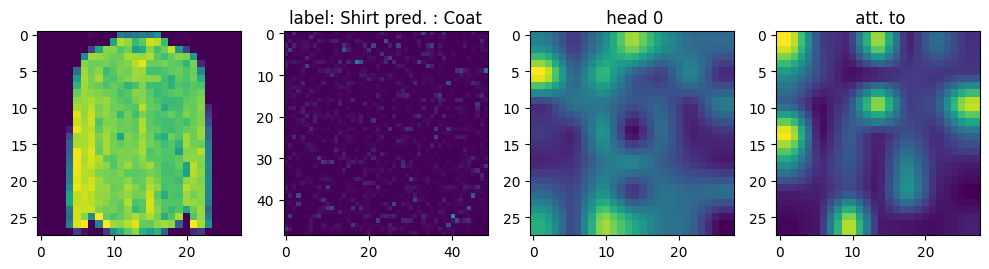

ic| t: 44


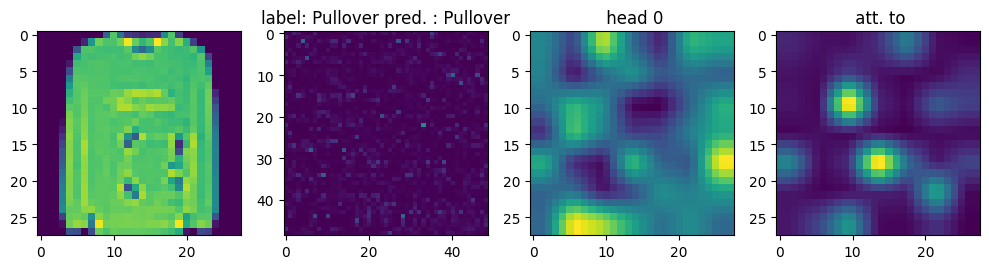

ic| t: 46


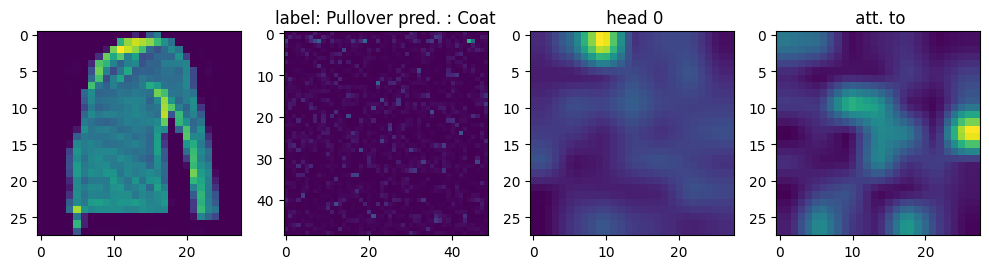

ic| t: 48


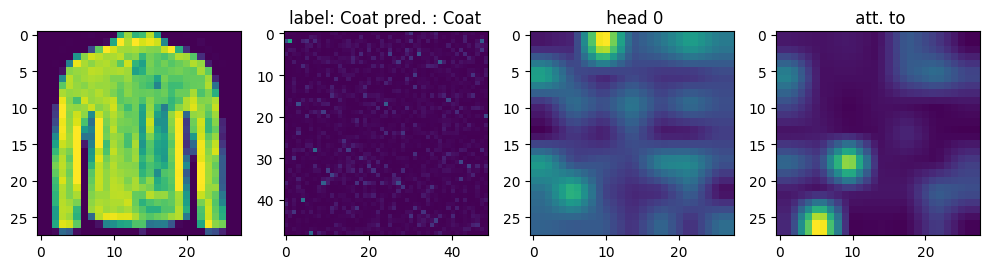

ic| t: 50


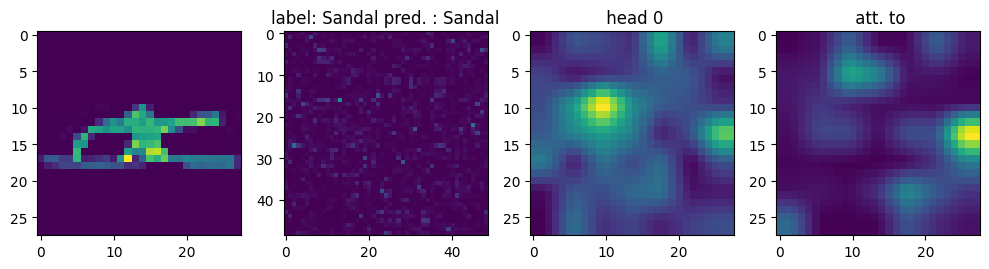

ic| t: 52


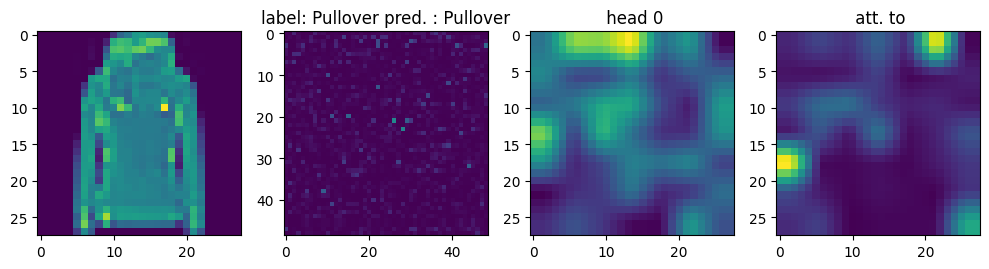

ic| t: 54


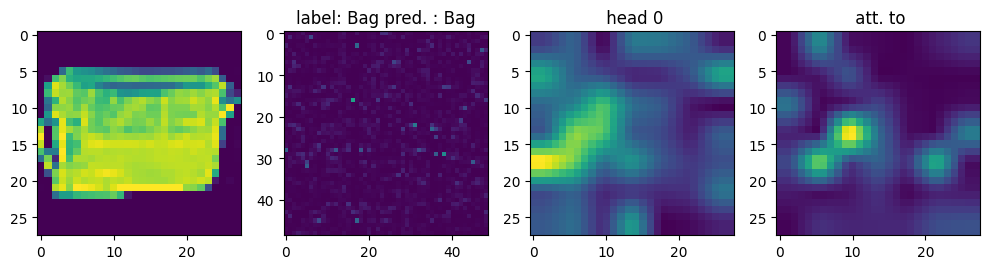

ic| t: 56


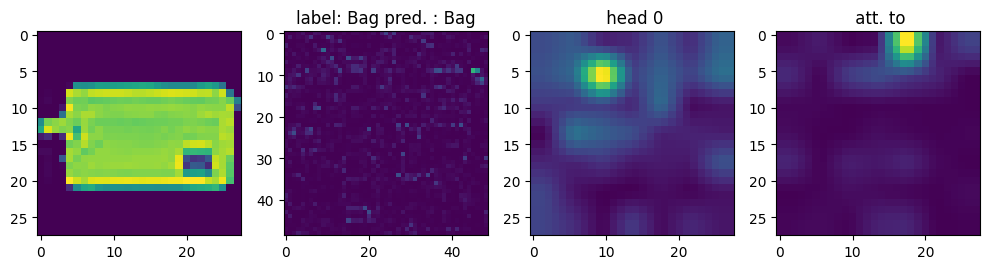

ic| t: 58


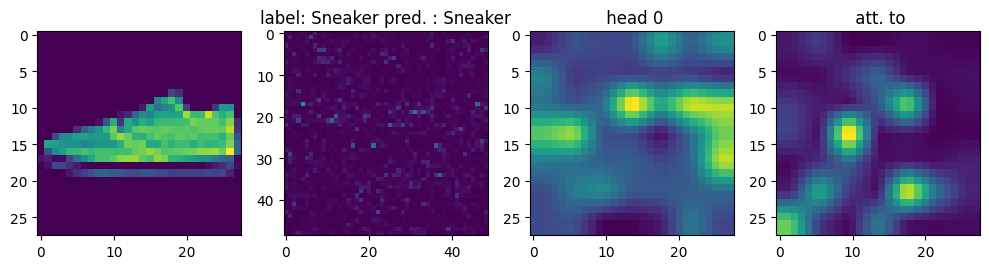

ic| t: 60


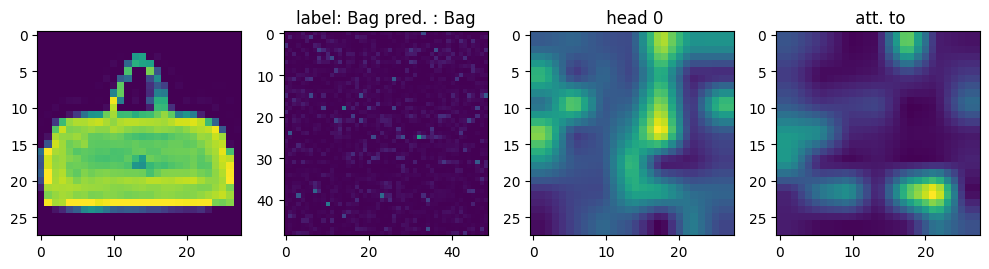

ic| t: 62


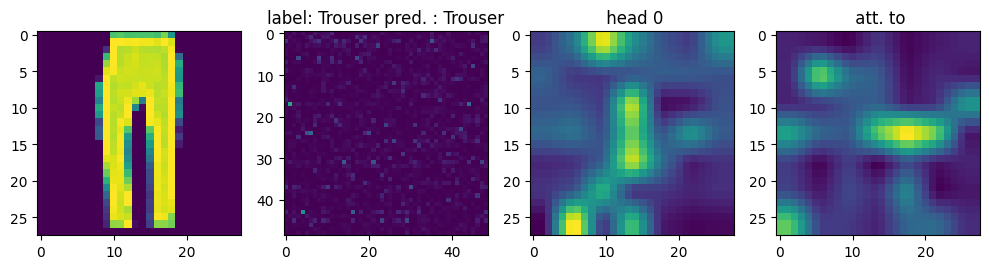

ic| t: 64


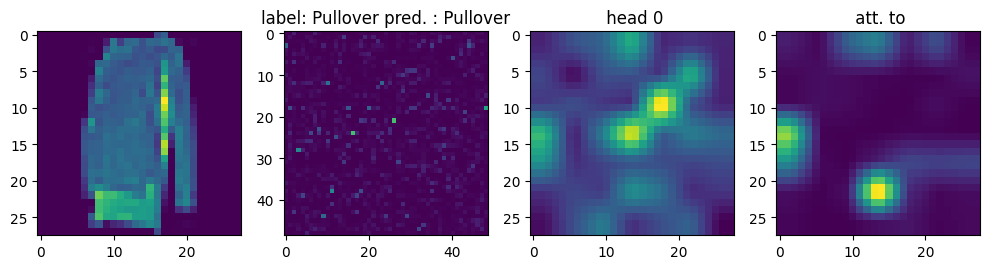

ic| t: 66


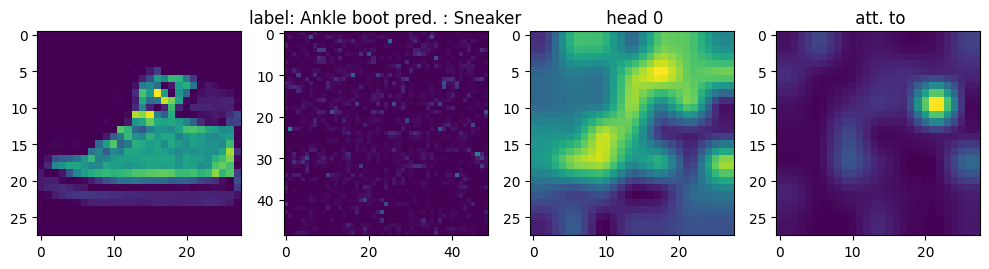

ic| t: 68


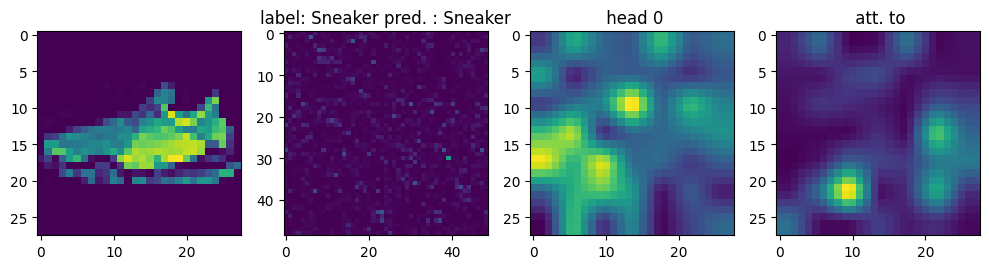

ic| t: 70


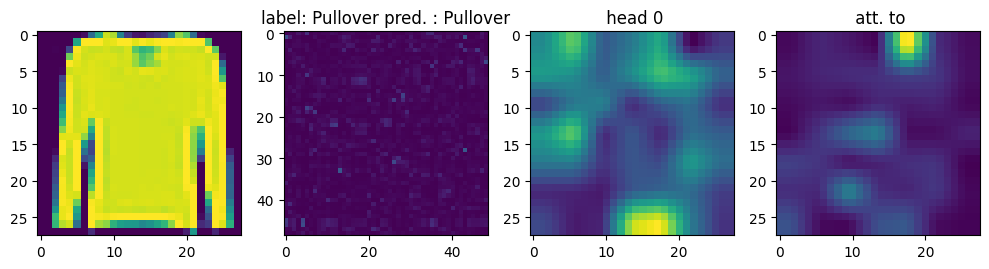

ic| t: 72


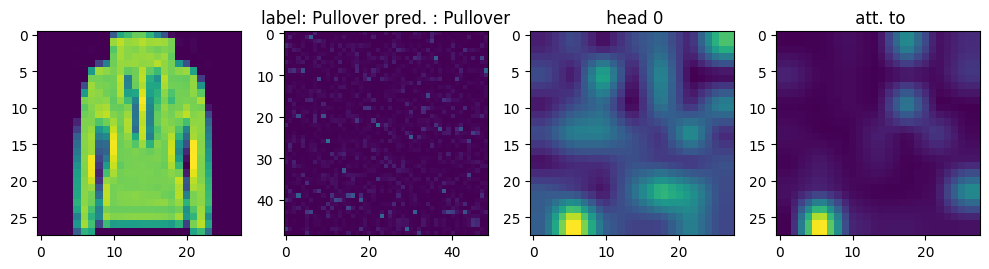

ic| t: 74


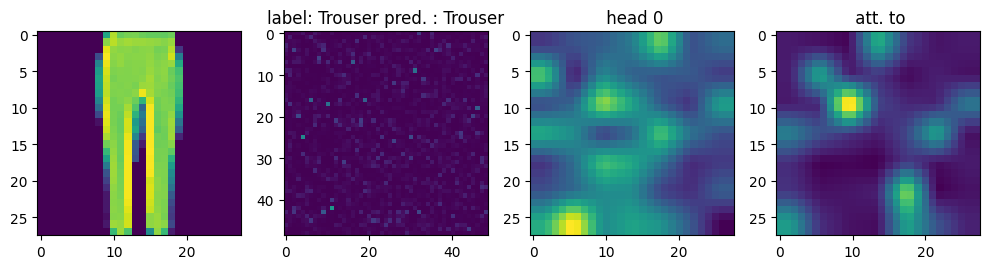

ic| t: 76


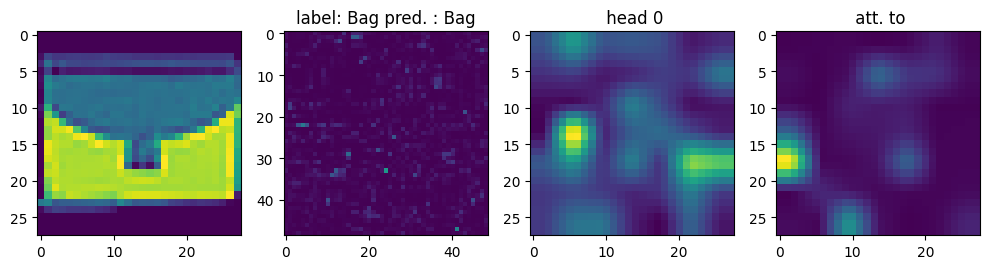

ic| t: 78


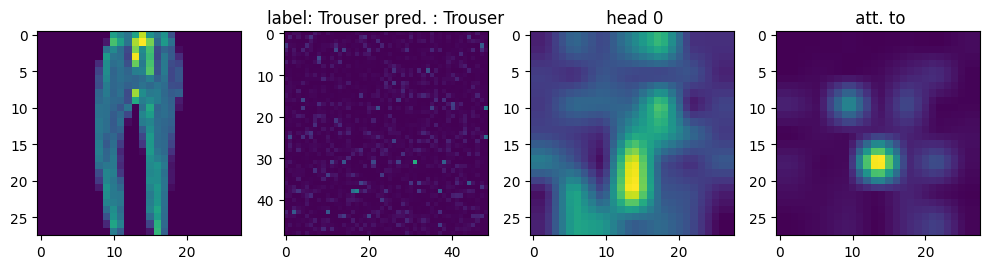

ic| t: 80


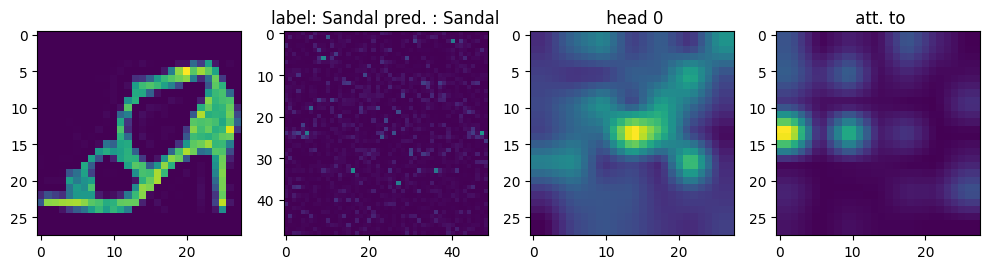

ic| t: 82


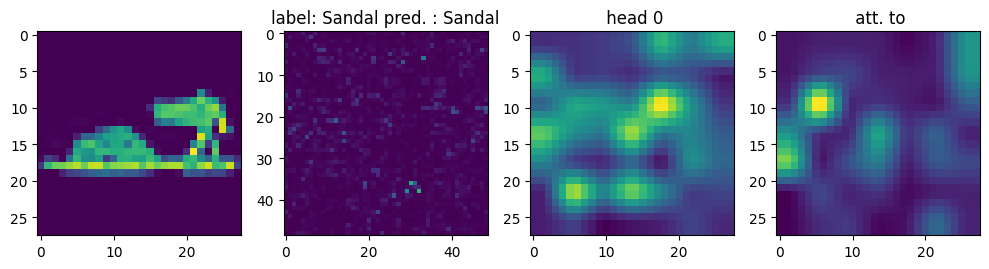

ic| t: 84


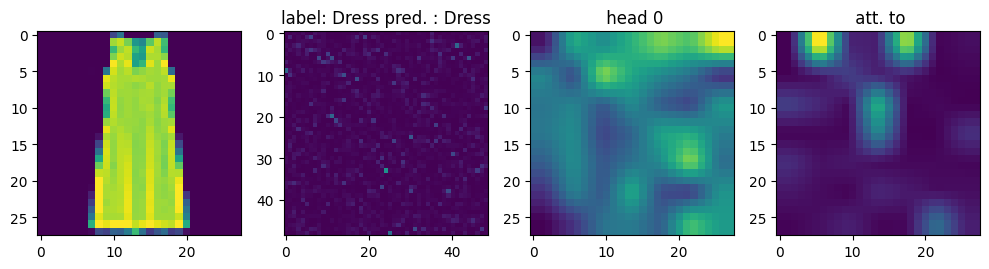

ic| t: 86


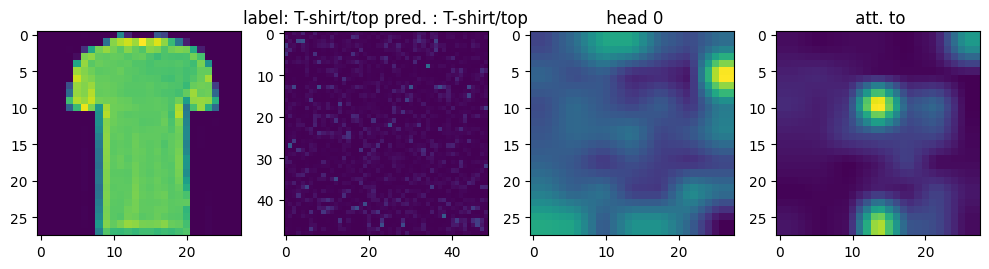

ic| t: 88


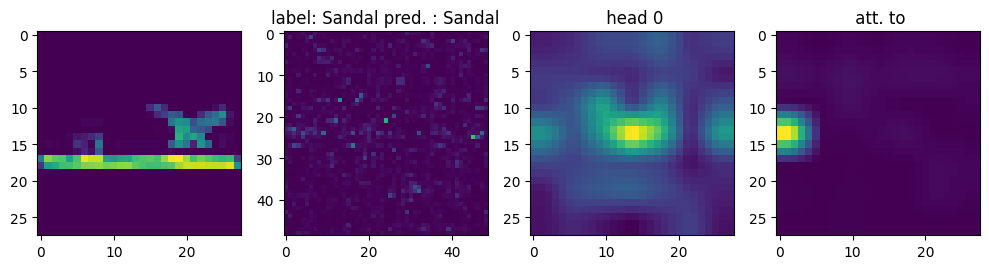

ic| t: 90


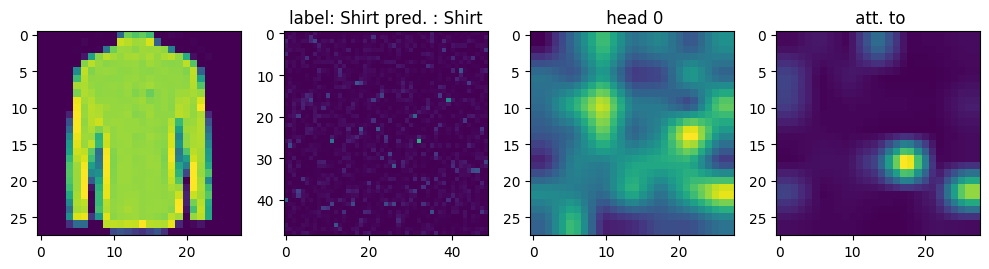

ic| t: 92


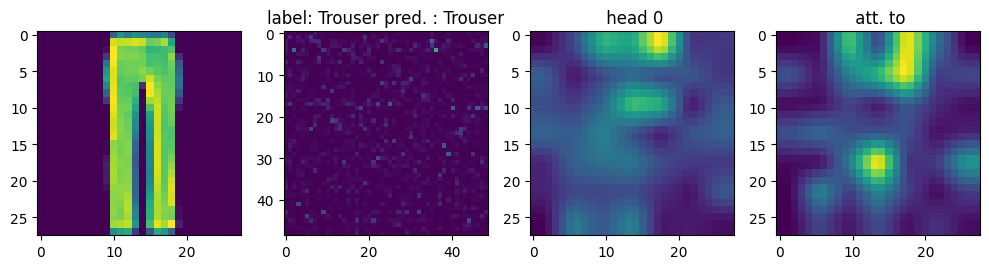

ic| t: 94


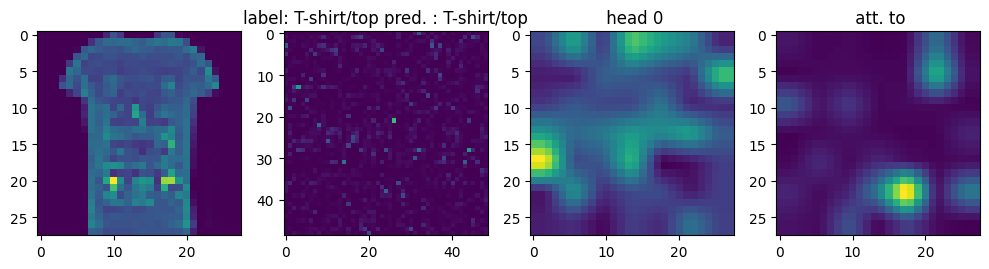

ic| t: 96


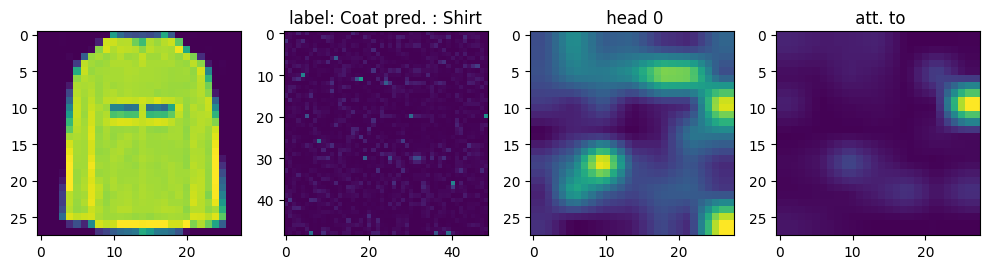

ic| t: 98


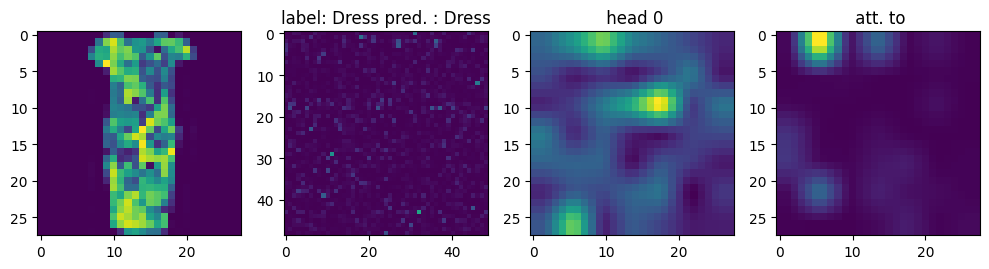

ic| t: 100


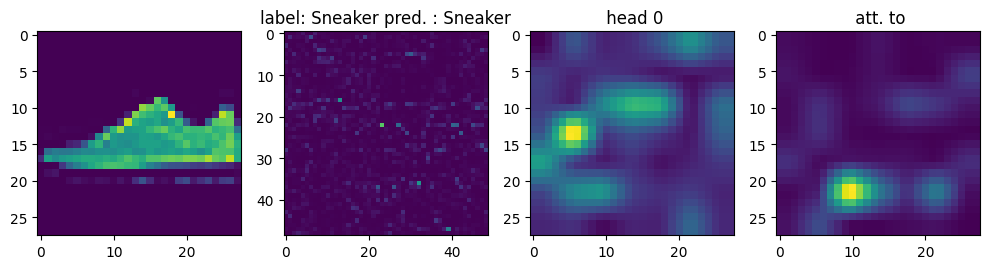

ic| t: 102


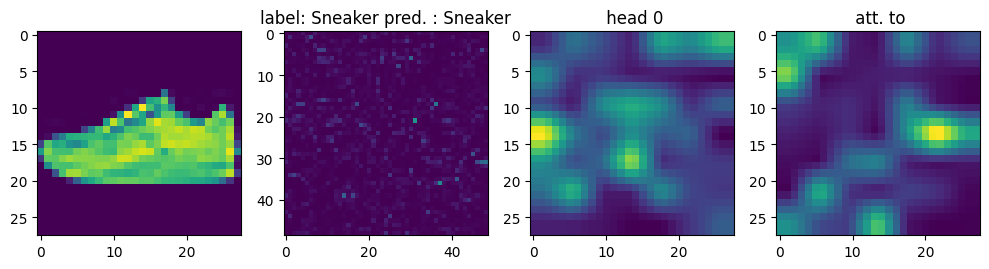

ic| t: 104


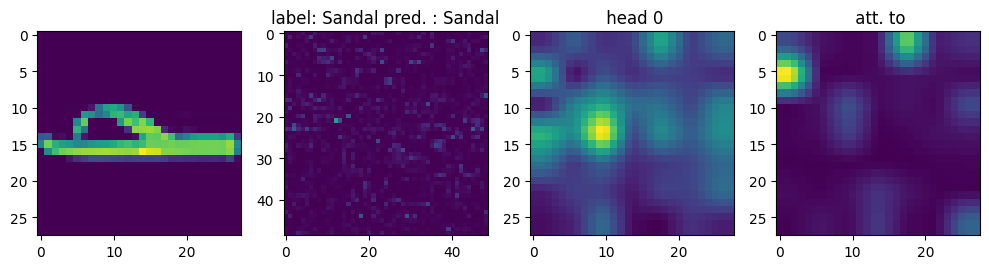

ic| t: 106


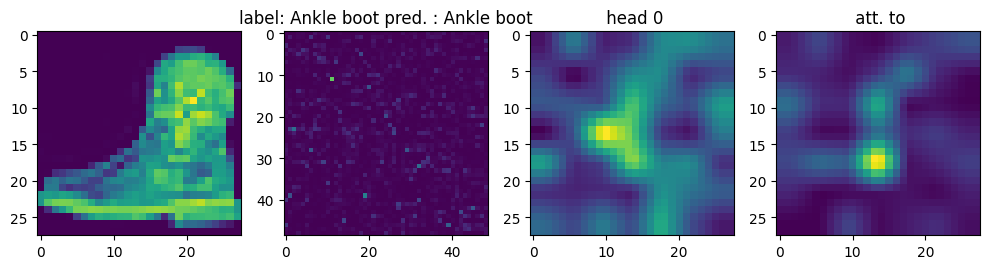

ic| t: 108


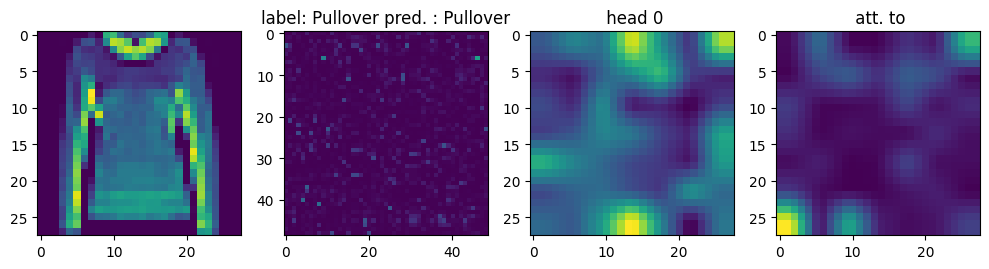

ic| t: 110


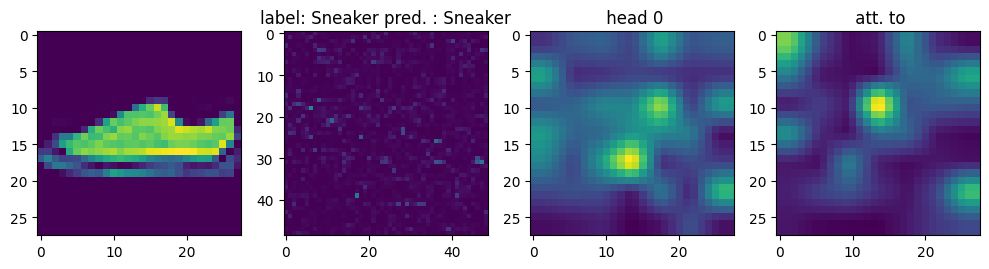

ic| t: 112


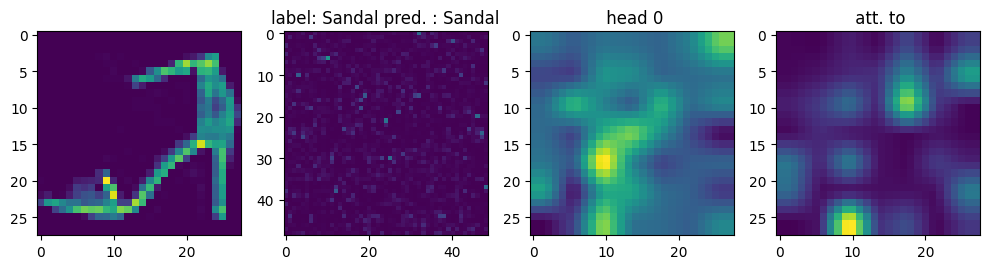

ic| t: 114


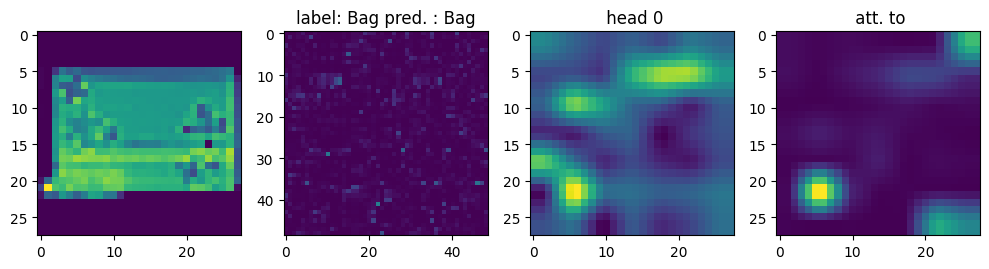

ic| t: 116


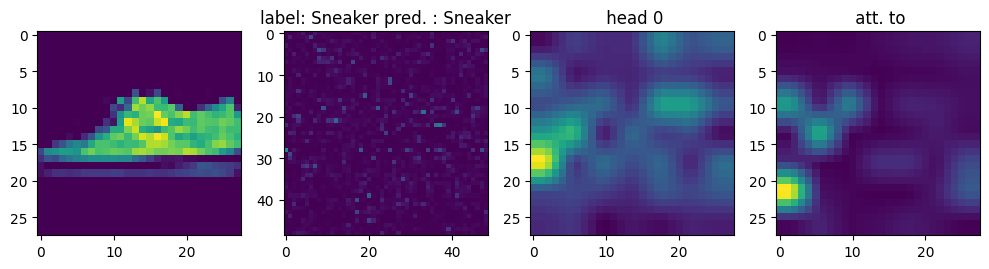

ic| t: 118


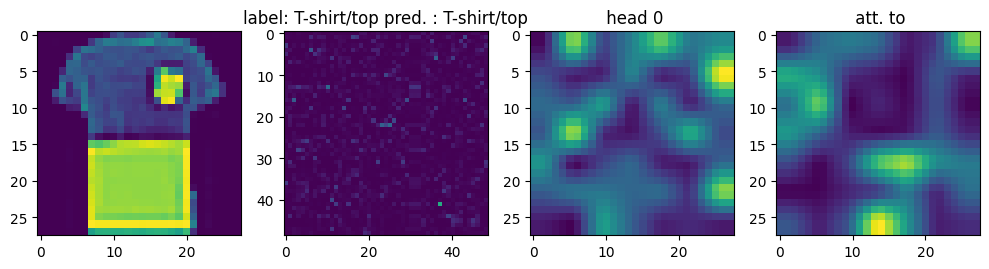

ic| t: 120


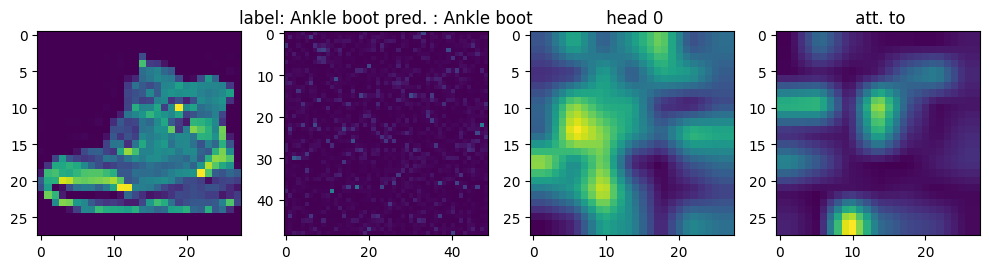

ic| t: 122


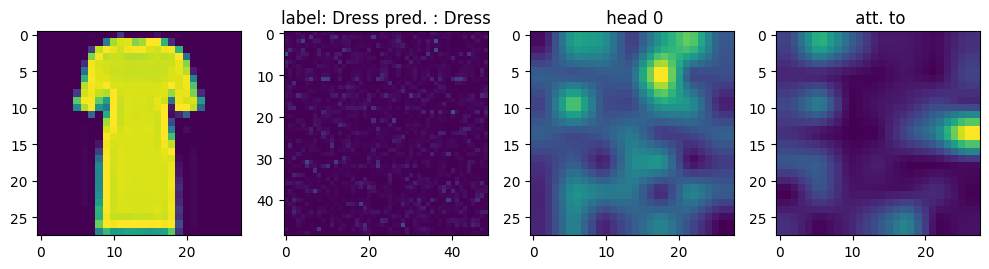

ic| t: 124


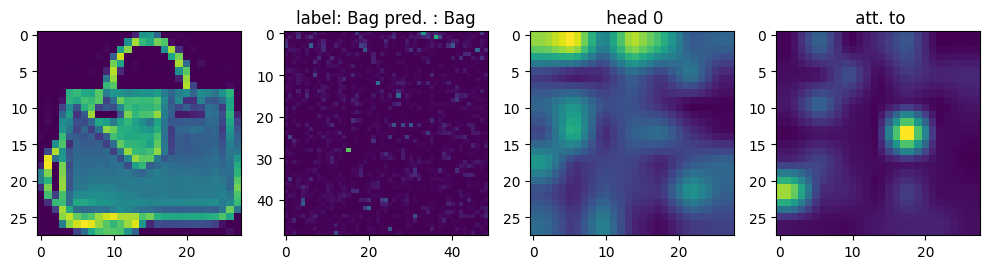

ic| t: 126


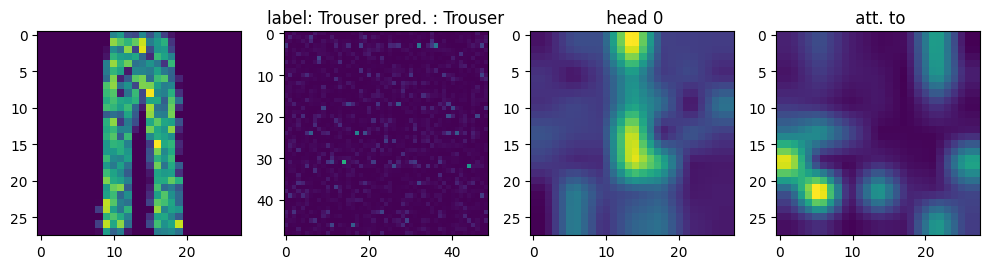

ic| t: 128


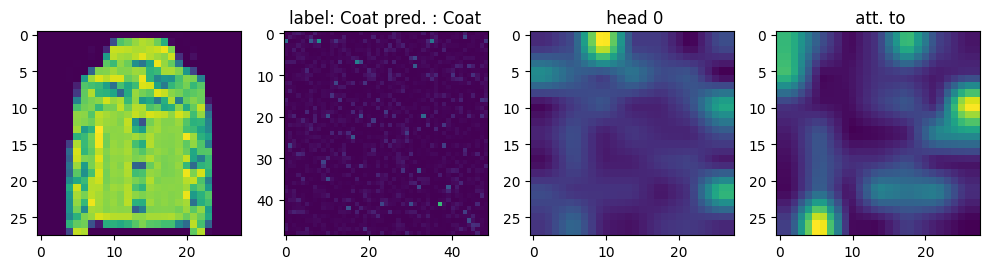

ic| t: 130


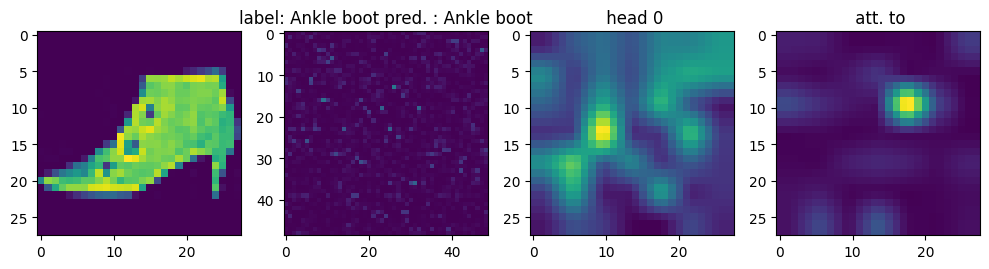

ic| t: 132


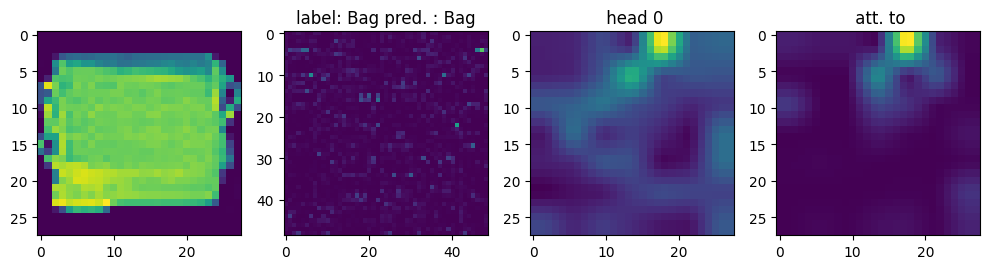

ic| t: 134


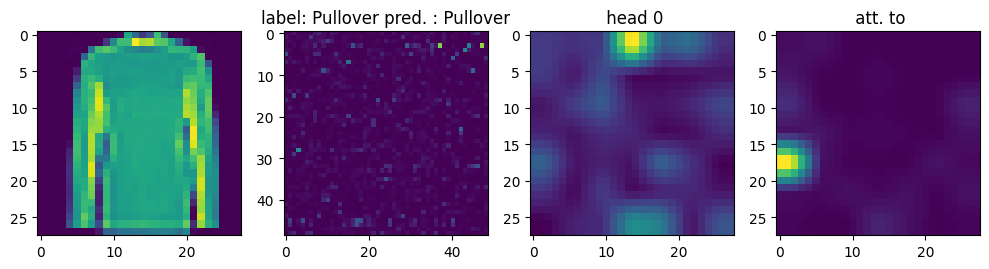

ic| t: 136


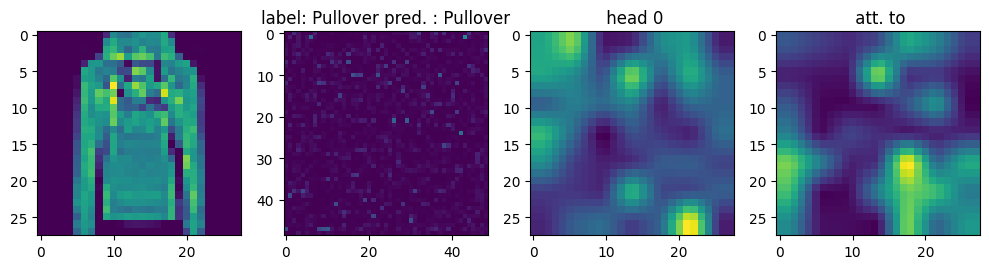

ic| t: 138


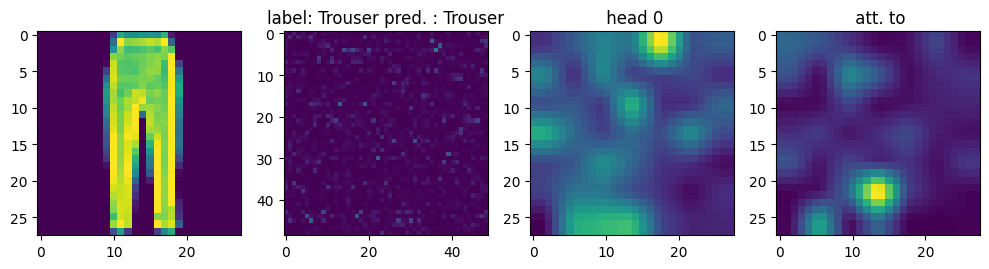

ic| t: 140


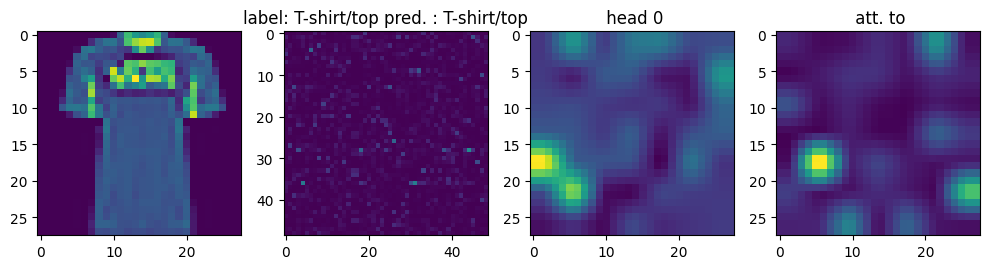

ic| t: 142


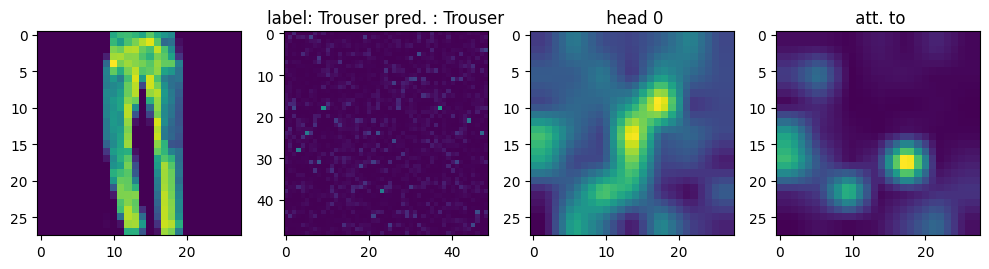

ic| t: 144


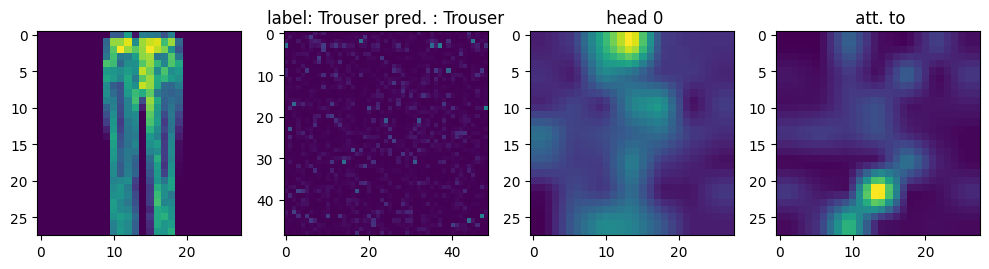

ic| t: 146


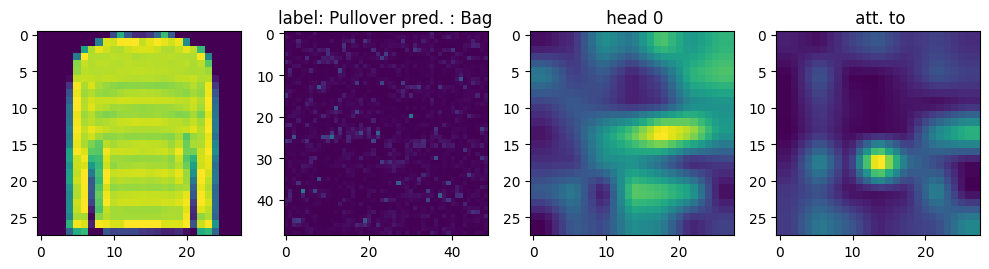

ic| t: 148


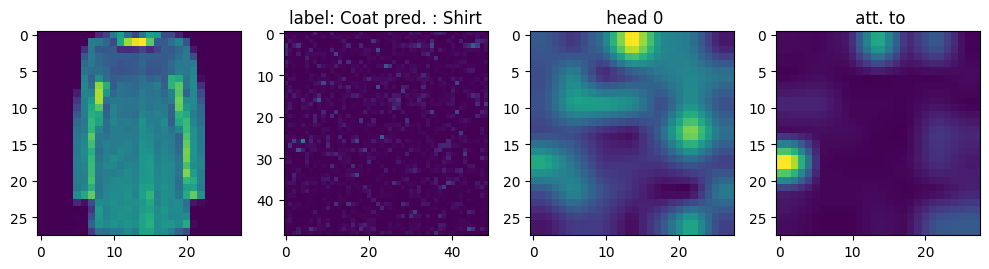

ic| t: 150


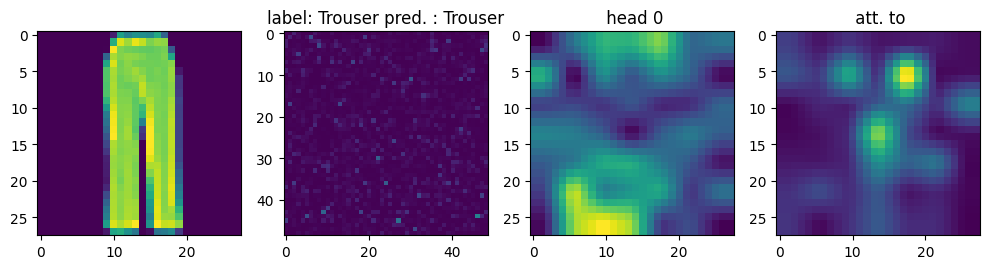

ic| t: 152


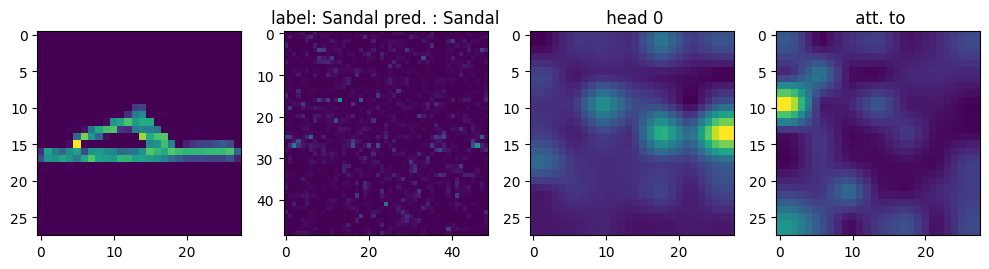

ic| t: 154


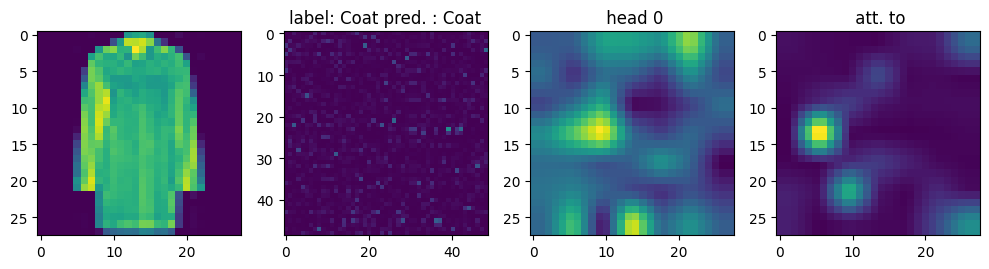

ic| t: 156


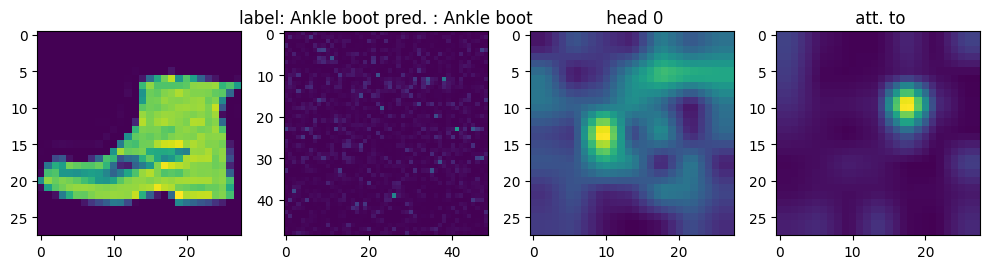

ic| t: 158


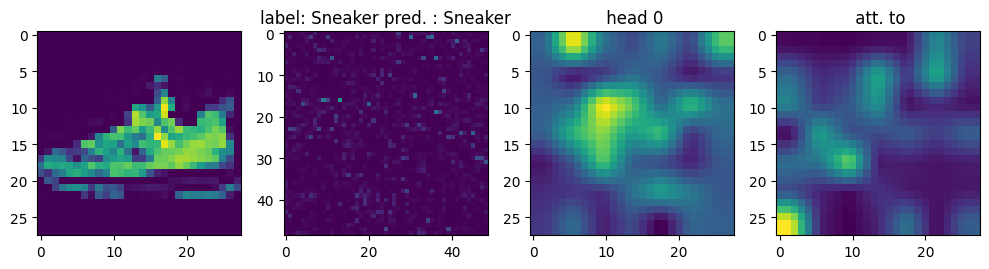

ic| t: 160


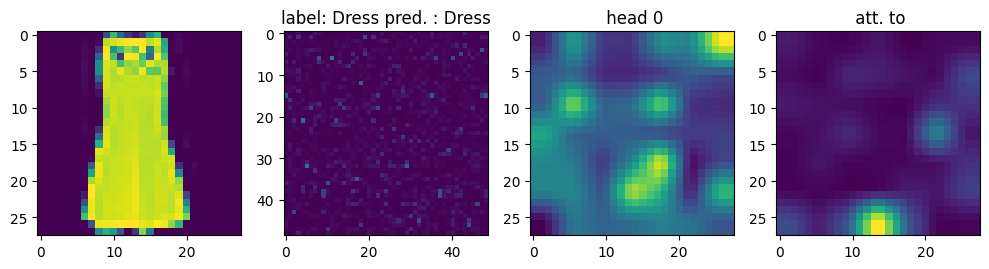

ic| t: 162


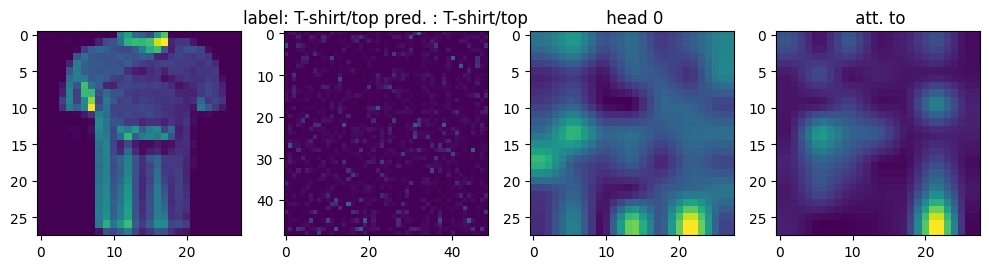

ic| t: 164


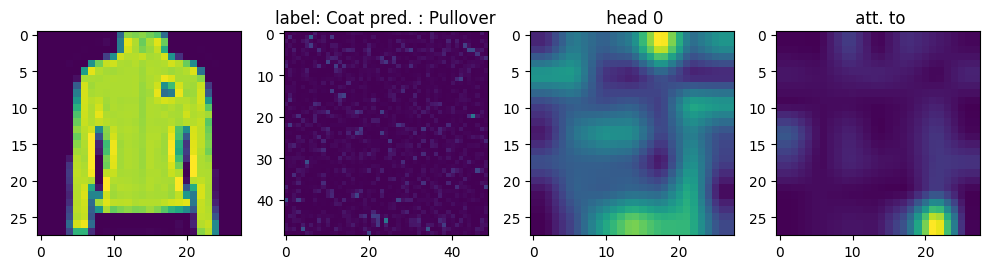

ic| t: 166


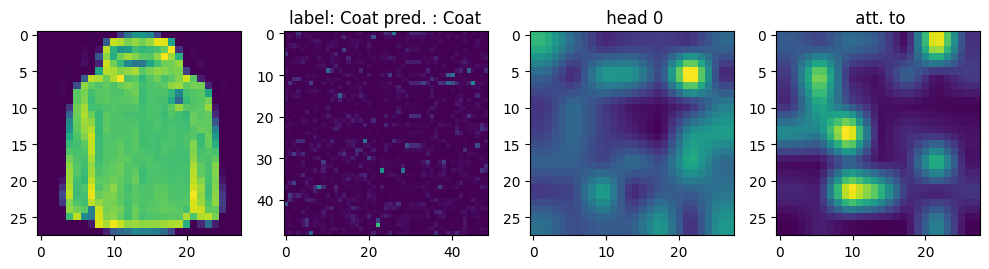

ic| t: 168


In [54]:
for c in range(80):
    
    if True:
        
        if n_head == 1:
            fig, axes = plt.subplots(1,4 , figsize=(10,7))
            axes = axes[None]
        else:
            fig, axes = plt.subplots(n_head,4 , figsize=(10,n_head*3))
        
        
        with torch.no_grad():
            pred0 = model_outputs_test[t*block_size:t*block_size + block_size]
#             pred0.shape
        pred0 = pred0.copy()
        
        # input_array = dmData.get_data().toarray()[t*block_size:t*block_size + block_size]  #/255 -.5
        # print(predicts[:, value_dim: value_dim + 2*embeding_dim].shape)
        # print(np.pad(input_array, [(0,0),(embeding_dim, embeding_dim)], 'reflect') [:,:2*embeding_dim].shape) 
        # train_data = np.pad(input_array, [(0,0),(embeding_dim, 0)], 'reflect') [:,:embeding_dim]
        # if use_input:
        #     pred0[:, value_dim: value_dim + 2*embeding_dim] +=   np.concatenate([train_data,train_data], axis=-1)
        # np.pad(input_array, [(0,0),(embeding_dim, embeding_dim)], 'reflect') [:,:2*embeding_dim]
        # pred0[:, value_dim: value_dim + 2*embeding_dim] +=  np.pad(input_array, 
        #                                                            [(0,0),(embeding_dim, embeding_dim)],
        #                                                            'reflect') [:,:2*embeding_dim]
        pred0 = torch.from_numpy(pred0).float().requires_grad_(False)
        with torch.no_grad():
            values = pred0[:, :value_dim].reshape(-1,block_size,value_dim)
    
            
    
            
            keys = pred0[:, value_dim: value_dim + embeding_dim].reshape(-1,block_size,embeding_dim)
            queries = pred0[:, value_dim + embeding_dim:value_dim + 2*embeding_dim] .reshape(-1,block_size, embeding_dim)
            # keys = pred0[:, value_dim: value_dim + embeding_dim].reshape(-1,block_size,embeding_dim)
            # queries = pred0[:, value_dim + embeding_dim:value_dim + 2*embeding_dim] .reshape(-1,block_size, embeding_dim)
            B, T, C = keys.size()
            
            keys = keys.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
            queries = queries.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
            values = values.view(B, T, n_head, value_dim // n_head).transpose(1, 2) # (B, nh, T, hs)
    
            if False:
                # efficient attention using Flash Attention CUDA kernels
                y = torch.nn.functional.scaled_dot_product_attention(queries, keys, values)
            else:
                # manual implementation of attention
                att = (queries @ keys.transpose(-2, -1)) * (1.0 / np.sqrt(keys.size(-1)))
                # att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf')) # causal implementation 
                att = F.softmax(att, dim=-1)
                # att = F.relu(att)
                y = att @ values  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
            output_seq = y.transpose(1, 2).contiguous().view(B, T, value_dim) # re-assemble all head outputs side by side
            output = (output_seq[:,:,:]).sum(1) #
            # ic(F.softmax(output,dim=-1))
            for i, head in enumerate(att[0]):
                axes[i,0].imshow(Testset.data[t])
                
                axes[i,1].imshow(head.T,vmin=0, vmax=1)
                # axes[i,1].imshow(F.relu(head.T),vmin=0)
                # axes[i,1].imshow(head.T)
                tttt = Testset.classes[preds[t]]
                axes[i,1].set_title('label: ' + str(Testset.classes[Testset.targets[t]]) + ' pred. : ' +  tttt )
                # plt.show()

                attention_mask = head.sum(0).reshape(int(block_size**.5),int(block_size**.5)).numpy()
    #             print( att.sum(0))
                image = cv2.resize(attention_mask, (28, 28))
                # ic(image)
                axes[i,2].imshow(image)
                axes[i,2].set_title(f' head {i}')

                index_max = head.sum(0).argmax()
                att_to = head[index_max].reshape(int(block_size**.5),int(block_size**.5)).numpy()
                axes[i,3].imshow(cv2.resize(att_to, (28, 28)))
                axes[i,3].set_title(f' att. to')
        #         axes[2].imshow(attention_mask)
    
        #         axes[2].imshow(att.sum(0).reshape(int(len(tiles)**.5),int(len(tiles)**.5)), interpolation="bicubic")
            fig.tight_layout()   
            plt.show()
    
    ic(t)
    t+=2

In [35]:
# itert = iter(TestLoader)


In [36]:
# index_max = head.sum(0).argmax()
# att_to = head[index_max].reshape(int(block_size**.5),int(block_size**.5)).numpy()

# plt.imshow(cv2.resize(att_to, (28, 28)),vmin=0, vmax=.1)
# plt.show()

In [37]:
head[index_max]

tensor([0.0276, 0.0050, 0.0040, 0.0243, 0.1092, 0.0159, 0.0041, 0.0410, 0.0040,
        0.0009, 0.0018, 0.0018, 0.0031, 0.0033, 0.0200, 0.0018, 0.0010, 0.0156,
        0.0038, 0.0099, 0.0037, 0.0086, 0.0099, 0.2969, 0.0121, 0.0238, 0.0023,
        0.0078, 0.0018, 0.1662, 0.0040, 0.0009, 0.0037, 0.0020, 0.0076, 0.0004,
        0.0658, 0.0185, 0.0068, 0.0222, 0.0113, 0.0015, 0.0052, 0.0042, 0.0004,
        0.0025, 0.0008, 0.0017, 0.0091])